## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants
import seaborn as sns
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [4]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
TIC_ID = 22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149
stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)
teff = 3183.4  # gaia dr3
pub_teff =  ufloat(3422, 81) 


## Read RVs

In [5]:
spirou_lbl2 = pd.read_table('./data/toi4438/lbl2_TOI4438_GL699_oct24.rdb', sep=None, engine='python', header=0)
spirou_lbl = pd.read_table('./data/toi4438/lbl_TOI4438_GL699_oct24.rdb', sep=None, engine='python', header=0)
spirou_lbl2_star = pd.read_table('./data/toi4438/lbl2_TOI4438_TOI4438_oct24.rdb', sep=None, engine='python', header=0)
spirou_lbl_star = pd.read_table('./data/toi4438/lbl_TOI4438_TOI4438_oct24.rdb', sep=None, engine='python', header=0)
carmenes = pd.read_table('./data/toi4438/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)

# substract 2400000 to the BJD time of carmenes
carmenes['rjd'] = carmenes['rjd'] - 2400000
rv_inst_names = ['spirou', 'carmenes']

star_name = 'TOI 4438'

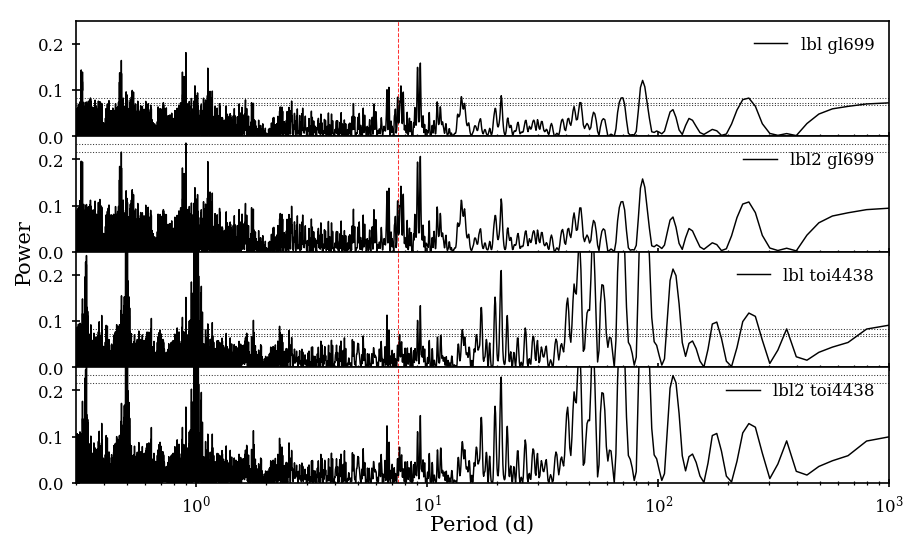

In [6]:
# check if the signal is present in any of the datasets
series = ['lbl gl699', 'lbl2 gl699', 'lbl toi4438', 'lbl2 toi4438']

lg = [ls(spirou_lbl.rjd, spirou_lbl.vrad, spirou_lbl.svrad),
      ls(spirou_lbl2.rjd, spirou_lbl2.vrad, spirou_lbl2.svrad),
      ls(spirou_lbl_star.rjd, spirou_lbl_star.vrad, spirou_lbl_star.svrad),
      ls(spirou_lbl2_star.rjd, spirou_lbl2_star.vrad, spirou_lbl2_star.svrad)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 0.25)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.1, 0.2])
    ax[i].tick_params(which='both', top=False, right=False)
    ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
    ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
    ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)
plt.savefig('./plots/toi4438/periodograms-by-reduction-template.png', dpi=200, facecolor='w', bbox_inches='tight')

In [7]:
# data to use:
spirou = spirou_lbl2.copy()

In [8]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,59732.984348,-35123.339550,2.684817,1.043918e+06,6328.720826,2.403151e+07,1.088609e+07,2762023o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19145.475297,5.788712e+06,...,-35139.390034,7.601509,-35142.893883,12.843459,-35280.679206,19.611389,-35105.266895,15.492288,-35116.606829,20.264180
1,59734.020205,-35115.946410,2.745255,1.069505e+06,6457.573123,1.358881e+07,1.114653e+07,2762205o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19146.511146,5.930593e+06,...,-35122.140386,7.376366,-35132.183793,12.007585,-35201.476702,19.581279,-35079.446363,16.539275,-35142.940695,23.804476
2,59735.057384,-35112.636920,2.773896,1.015229e+06,6503.845631,6.130288e+06,1.125506e+07,2762381o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19147.548289,5.629623e+06,...,-35123.091761,7.595824,-35098.204958,12.525014,-35180.871845,20.274103,-35089.119642,16.663927,-35108.679151,24.210202
3,59735.989705,-35112.440295,2.964496,1.106865e+06,6888.436365,1.333688e+07,1.198599e+07,2762545o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19148.480591,6.137765e+06,...,-35125.188503,7.993400,-35094.074535,12.553675,-35179.734518,22.399025,-35087.383232,19.841505,-35092.491642,30.758909
4,59736.952200,-35111.624217,2.746629,1.065654e+06,6422.196629,1.454986e+07,1.112226e+07,2762718o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19149.443098,5.909241e+06,...,-35111.950992,7.193619,-35120.029042,11.992340,-35196.388334,19.168963,-35116.723471,15.870437,-35107.100176,22.023753


In [9]:
carmenes.head()

,rjd,vrad,svrad
0,59720.6490,1.90,3.99
1,59726.5607,-6.93,2.02
2,59730.5751,-1.11,2.20
3,59736.5664,2.74,1.81
4,59738.6403,-3.77,1.97


### Outliers

<Axes: >

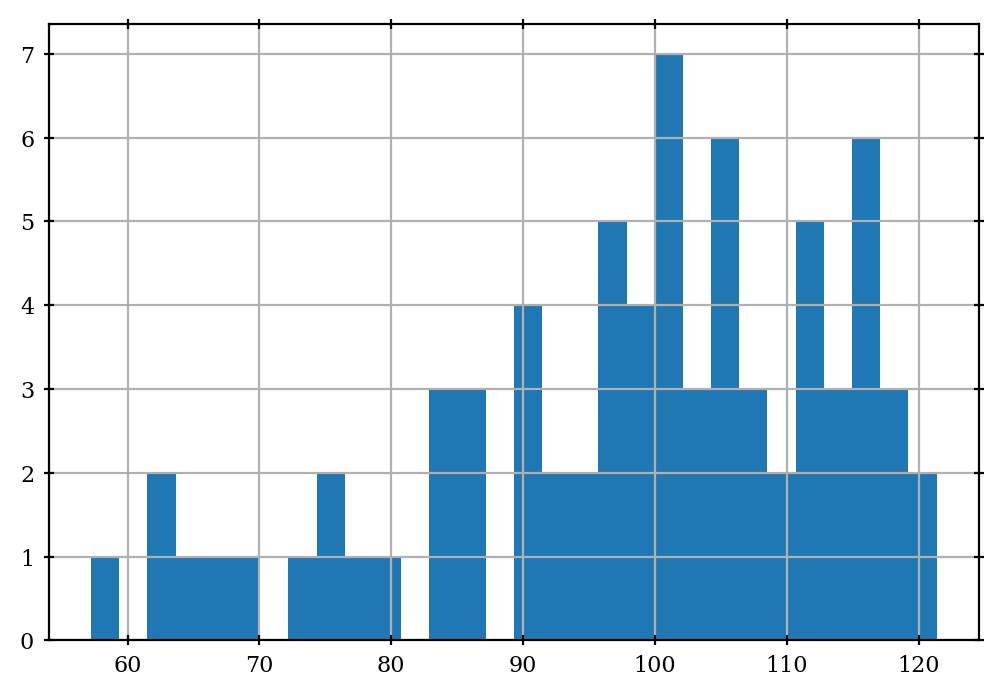

In [10]:
# remove low SNR points
spirou['EXTSN035'].hist(bins=30)

<Axes: >

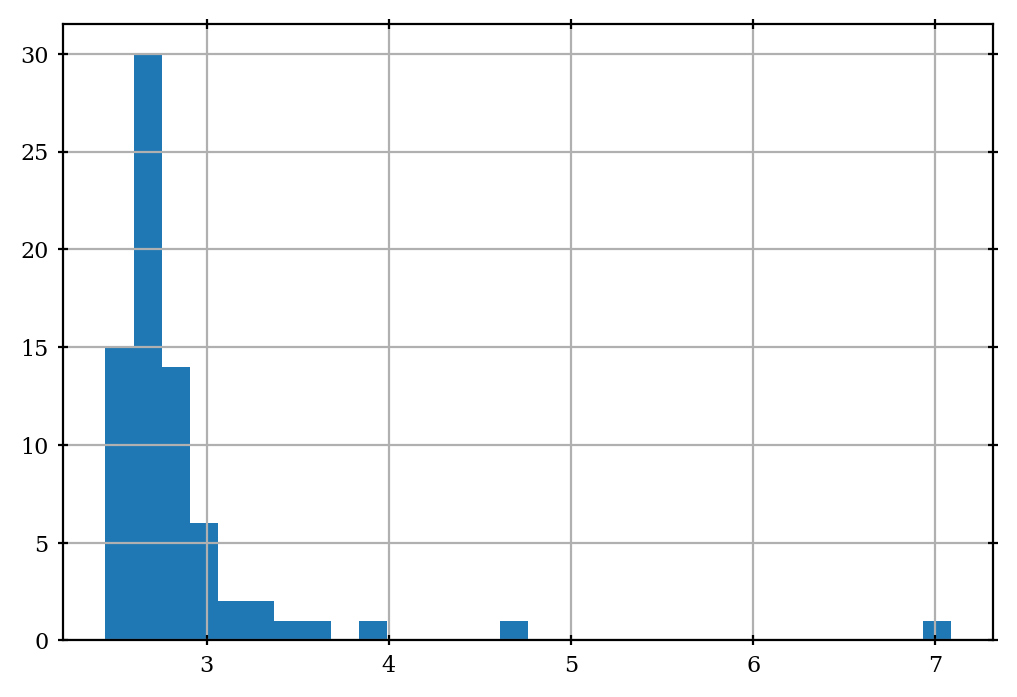

In [11]:
# remove low SNR points
spirou['svrad'].hist(bins=30)

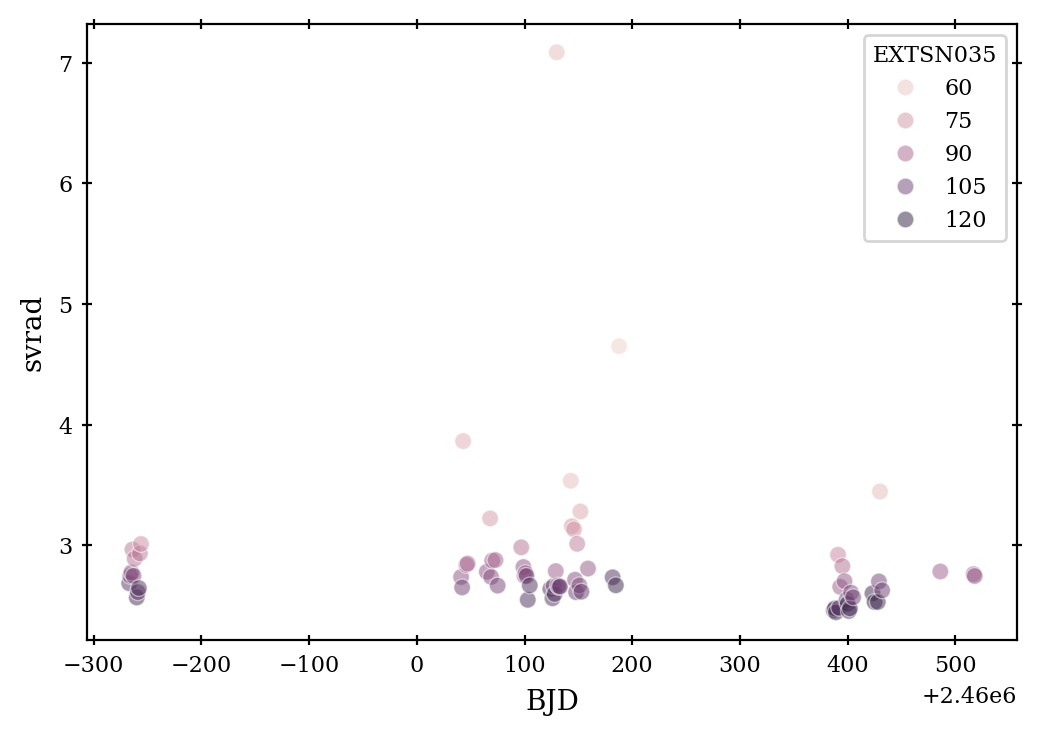

In [12]:
sns.scatterplot(data=spirou, x='BJD', y='svrad', hue='EXTSN035', alpha=0.5)
plt.show()

In [13]:
# drop low SNR points
spirou = spirou[spirou['EXTSN035'] > 60]
spirou = spirou[spirou['svrad'] < 5]

Text(0.5, 0, 'RV [km/s]')

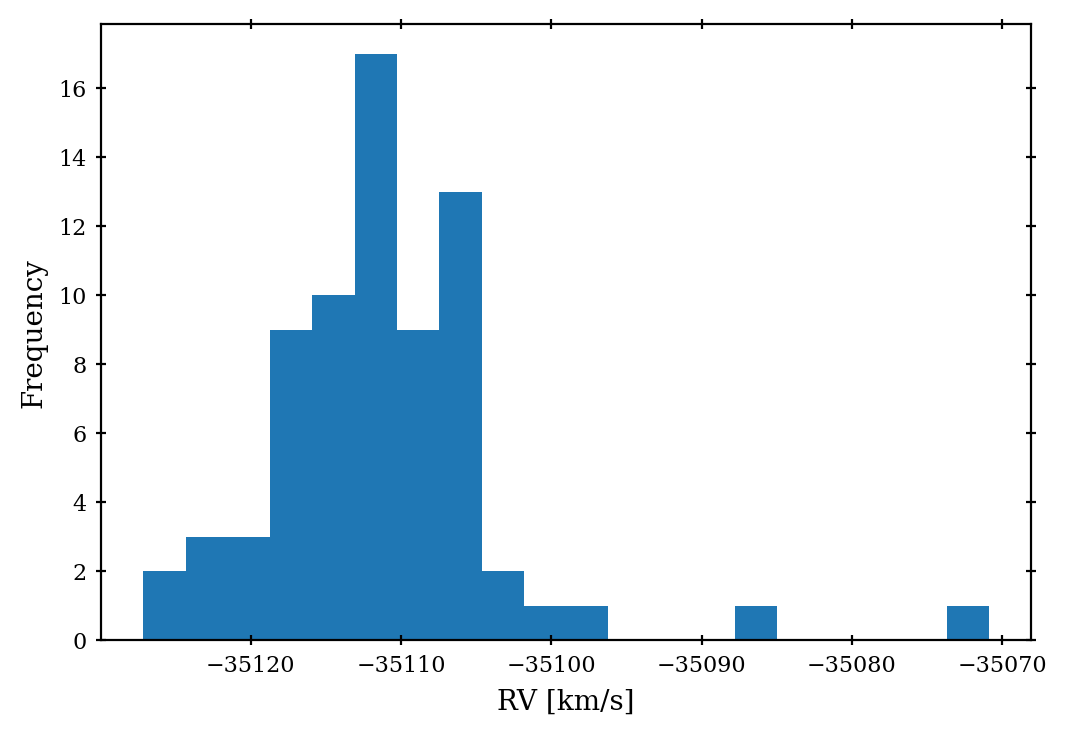

In [14]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: >

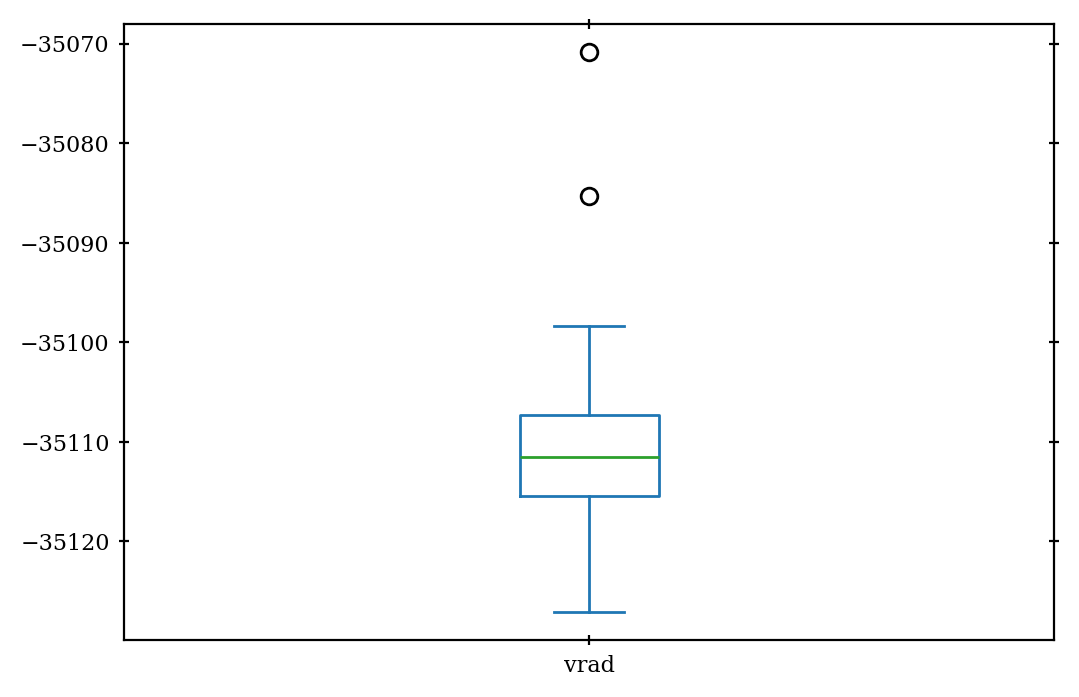

In [15]:
# boxplot
spirou.vrad.plot(kind='box')

In [16]:
# detect outliers using iqr
q1 = spirou.vrad.quantile(0.25)
q3 = spirou.vrad.quantile(0.75)
iqr = q3 - q1
mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# filter outliers
spirou = spirou[~mask]

# substract the median of the radial velocity
spirou['vrad'] = spirou['vrad'] - spirou['vrad'].median()

<Axes: >

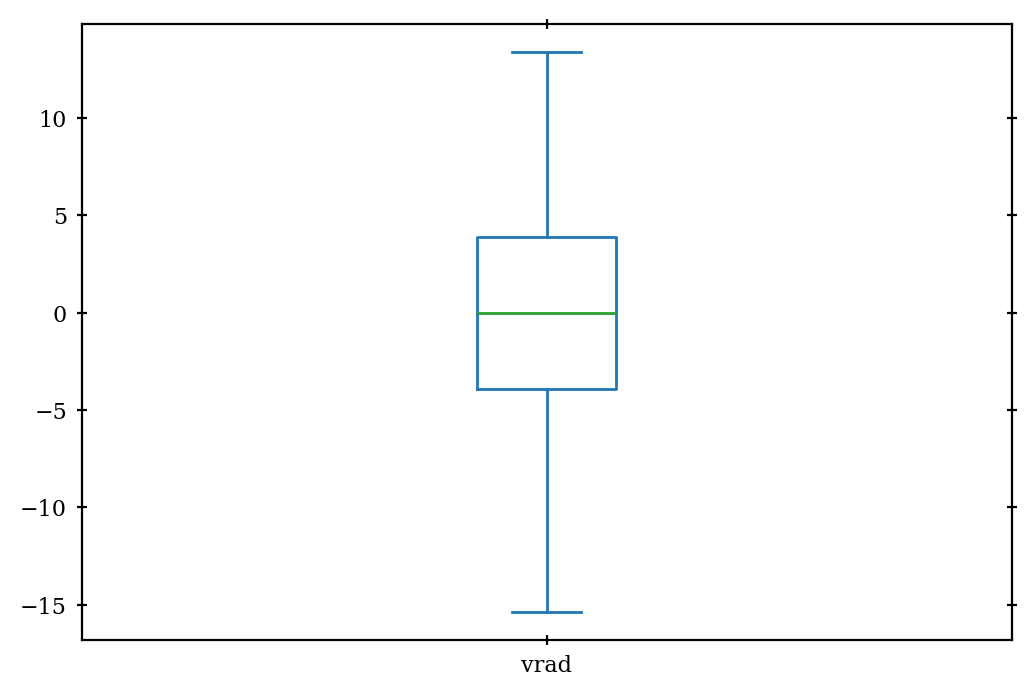

In [17]:
# after filtering
spirou.vrad.plot(kind='box')

### Plot RVs

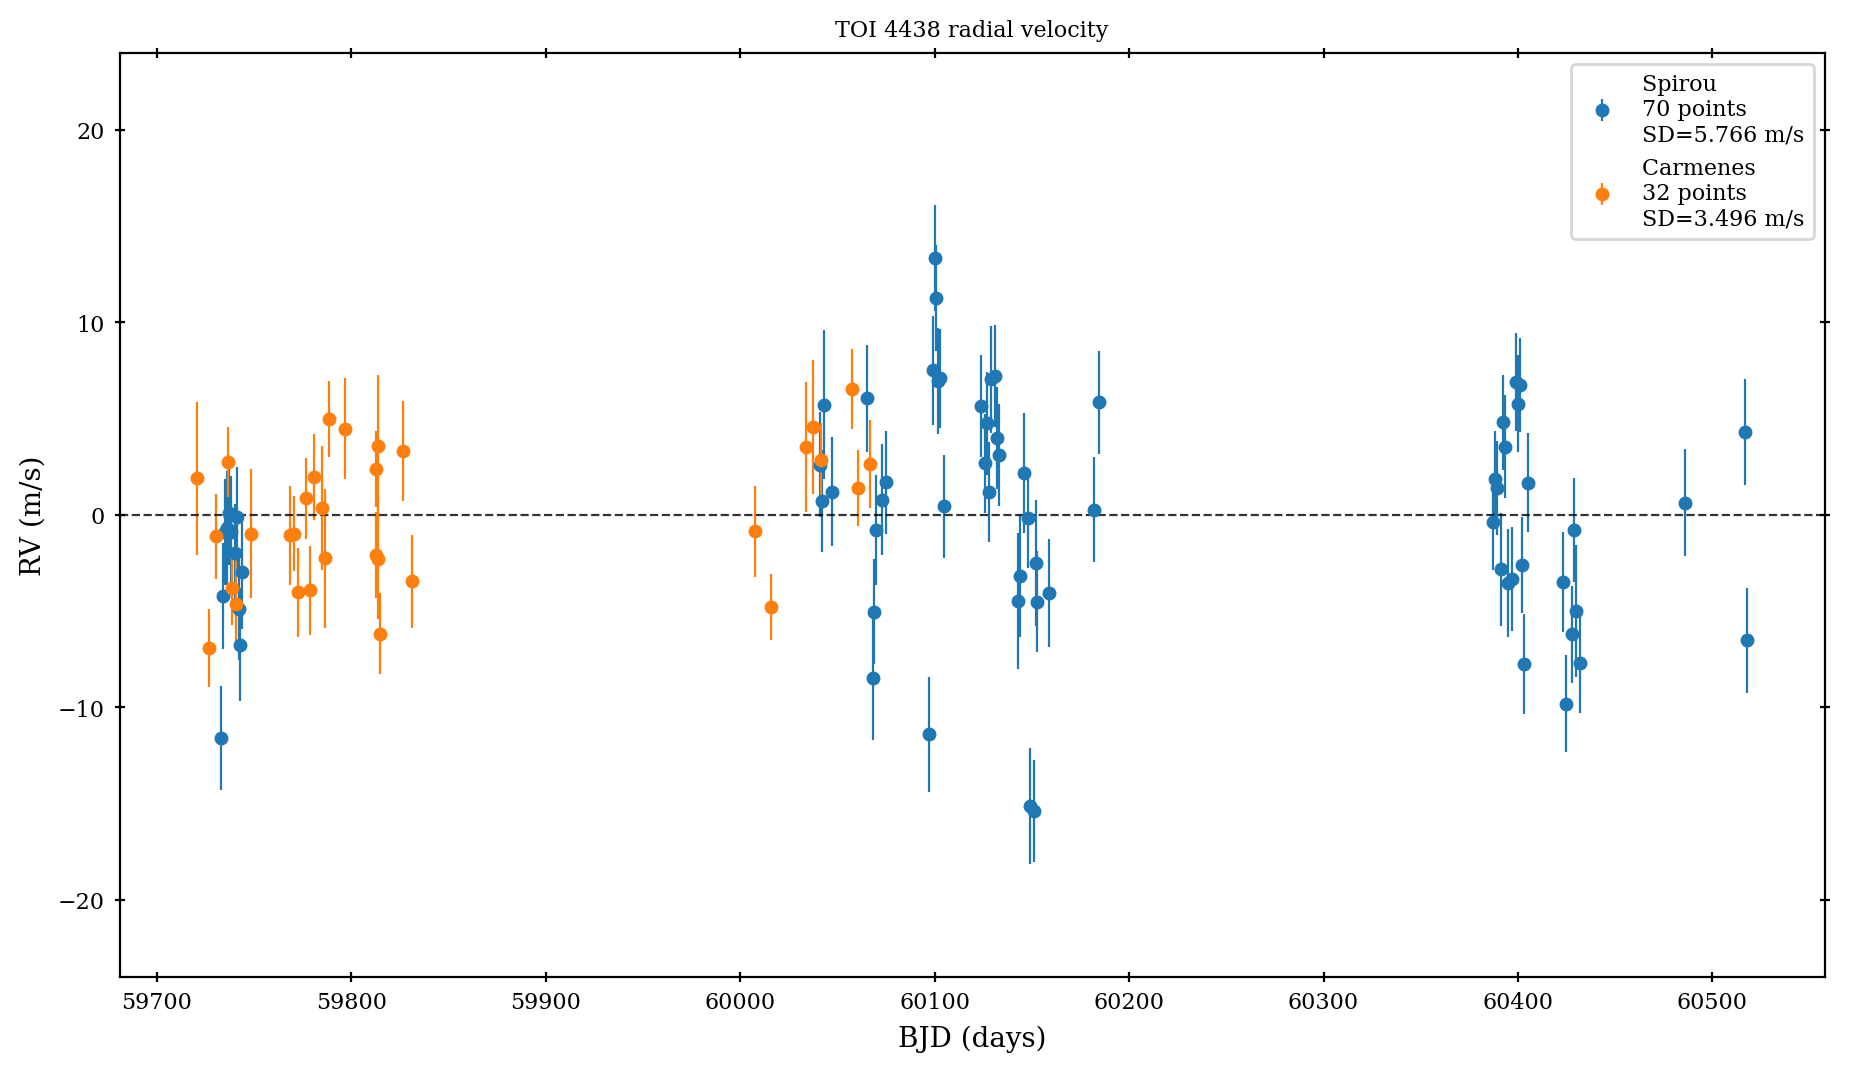

In [18]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C0')
ax.errorbar(carmenes['rjd'], carmenes['vrad'], yerr=carmenes['svrad'], fmt='o', label=f'Carmenes \n{len(carmenes)} points\nSD={np.round(np.std(carmenes.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C1')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
ax.legend()
ax.set_title(f'{star_name} radial velocity')
ax.set_ylim(-24, 24)
ax.set_xlabel('BJD (days)')
ax.set_ylabel('RV (m/s)')
plt.savefig('./plots/toi4438/all_rvs.png', dpi=200, facecolor='w', bbox_inches='tight')
plt.show()

### Define RV variables

In [19]:
# prepare the data for the model
x_rv = np.concatenate((spirou['rjd'], carmenes['rjd']))
y_rv = np.concatenate((spirou['vrad'], carmenes['vrad']))
yerr_rv = np.concatenate((spirou['svrad'], carmenes['svrad']))
rv_inst_id = np.concatenate((np.zeros(len(spirou)), np.ones(len(carmenes))))
inds = np.argsort(x_rv)

x_rv = np.ascontiguousarray(x_rv[inds], dtype=np.float64) - 57000
y_rv = np.ascontiguousarray(y_rv[inds], dtype=np.float64)
yerr_rv = np.ascontiguousarray(yerr_rv[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)

num_rv_inst = len(rv_inst_names)

### GLS analysis

In [20]:
series = ['spirou rvs', 'spirou dlw',  'carmenes rvs', 'all rvs', 'window function']

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(carmenes.rjd, carmenes.vrad, carmenes.svrad),
      ls(x_rv, y_rv, yerr_rv),
      ls(spirou.rjd, np.ones(len(spirou.rjd)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

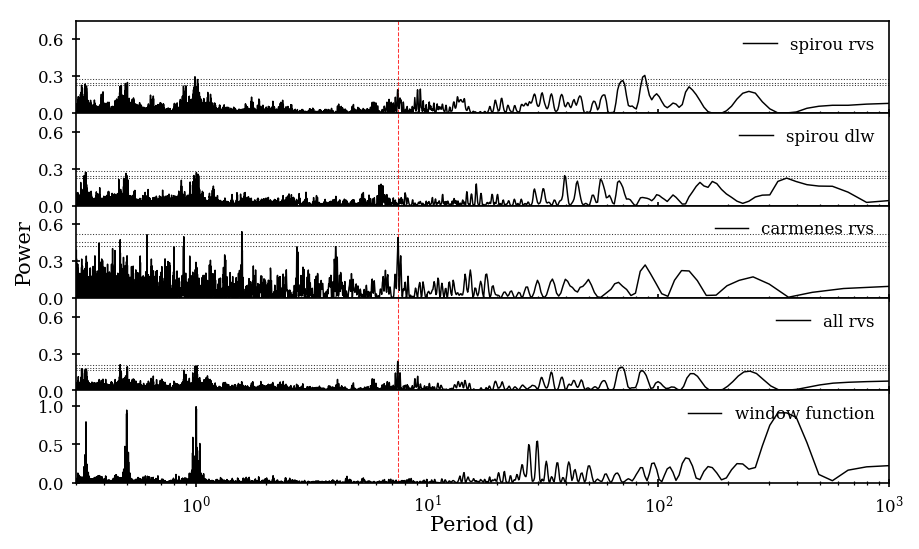

In [21]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 0.75)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.3, 0.6])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1.2)
        ax[i].set_yticks([0.0, 0.5, 1.0])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)
plt.savefig('./plots/toi4438/rv_periodograms.png', dpi=200, facecolor='w', bbox_inches='tight')

## Read LCs

In [22]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

In [23]:
tpf_search = lk.search_targetpixelfile('TIC 22233480')
tpf_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 80,2024,SPOC,20,22233480,0.0
5,TESS Sector 79,2024,SPOC,120,22233480,0.0
6,TESS Sector 80,2024,SPOC,120,22233480,0.0
7,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
8,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0


In [24]:
search = lk.search_lightcurve('TIC 22233480')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 80,2024,SPOC,20,22233480,0.0
5,TESS Sector 79,2024,SPOC,120,22233480,0.0
6,TESS Sector 80,2024,SPOC,120,22233480,0.0
7,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
8,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

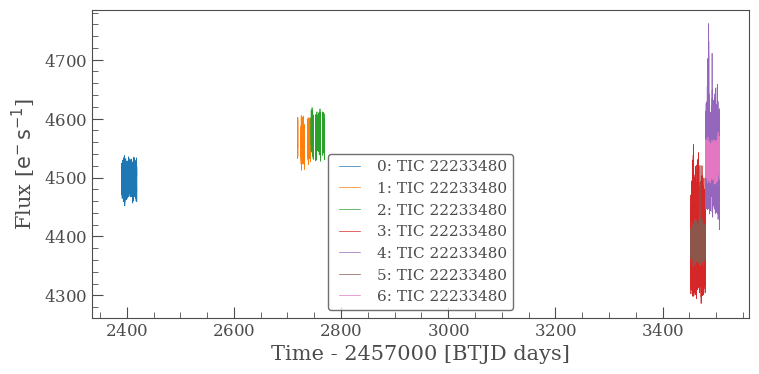

In [25]:
search[search.author == 'SPOC'].download_all().plot()

In [26]:
# save the lightcurves
lc_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53]).download_all(flux_column="pdcsap_flux")
lc_79_80_fast_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79, 80], exptime=20).download_all(flux_column="pdcsap_flux")
lc_79_80_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79, 80], exptime=120).download_all(flux_column="pdcsap_flux")
lc_short_all_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53, 79, 80]).download_all(flux_column="pdcsap_flux")

In [27]:
lc_short = lc_short_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_80_fast = lc_79_80_fast_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_80_fast_bin = lc_79_80_fast.bin(time_bin_size=120*u.s.to(u.day)).remove_nans()
lc_79_80_short = lc_79_80_short_file.stitch().remove_nans().normalize().remove_outliers()
lc_short_all = lc_short_all_file.stitch().remove_nans().normalize().remove_outliers()

In [28]:
# lets divide the lightcurve in 3 parts
lc1 = lc_short_all[lc_short_all.time.value < 2600]
lc2 = lc_short_all[(lc_short_all.time.value > 2600) & (lc_short_all.time.value < 2800)]
lc3 = lc_short_all[lc_short_all.time.value > 3400]

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

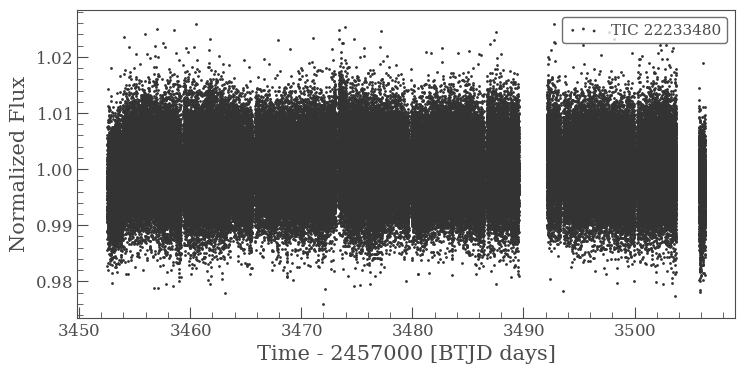

In [29]:
# plot sector 79 fast cadence
lc_79_80_fast.scatter()

(-0.5, 0.5)

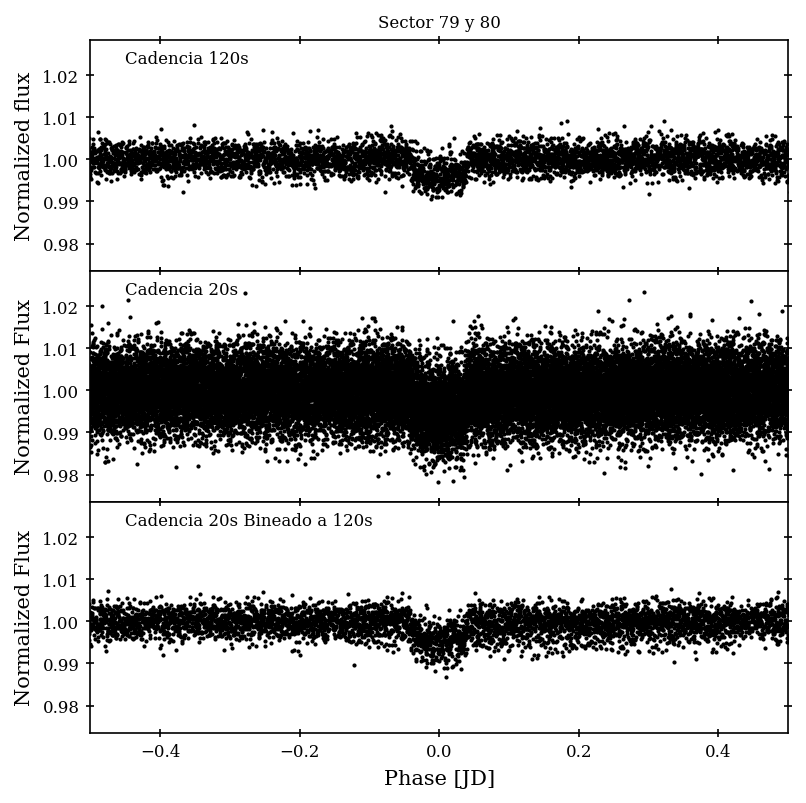

In [30]:
# sector 79 and 80 fast cadence
fig, ax = plt.subplots(3, 1, figsize=(6,6), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
lc_79_80_short.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[0], c='k', label='')
lc_79_80_fast.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[1], c='k', label='')
lc_79_80_fast_bin.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[2], c='k', label='')
ax[0].text(0.05, 0.9, 'Cadencia 120s', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'Cadencia 20s', transform=ax[1].transAxes)
ax[2].text(0.05, 0.9, 'Cadencia 20s Bineado a 120s', transform=ax[2].transAxes)
ax[0].set_title('Sector 79 y 80')
ax[0].set_ylabel('Normalized flux')
ax[0].set_xlabel('Phase')
plt.xlim(-0.5, 0.5)
#plt.savefig('lc_79.png', dpi=300)

### Asteroseismology?

(0.0, 5e-08)

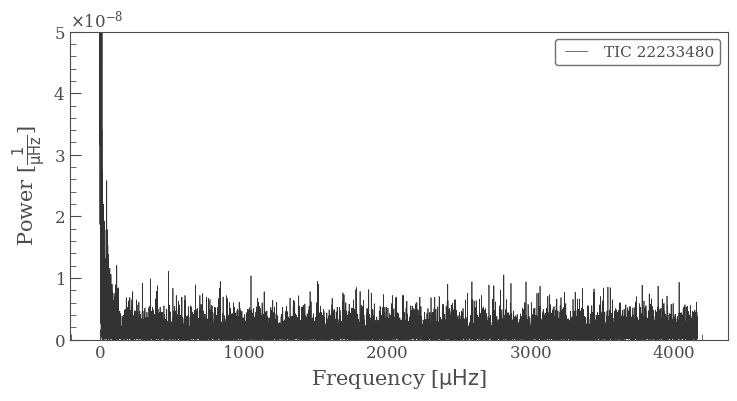

In [31]:
seism = lc_79_80_fast_bin.to_periodogram(normalization='psd')
ax = seism.plot()
#plt.xlim(500, 3500)
plt.ylim(0, 5e-8)

### LC to use

In [32]:
# for the model, short and fast cadence binned to short are concatenated 
time = np.concatenate((lc_short.time.value, lc_79_80_fast_bin.time.value))
flux = np.concatenate((lc_short.flux.value, lc_79_80_fast_bin.flux.value))
flux_err = np.concatenate((lc_short.flux_err.value, lc_79_80_fast.flux_err.value))

inds2 = np.argsort(time)
time = np.ascontiguousarray(time[inds2], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds2], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds2], dtype=np.float64)

# all sectors binned to 5 minutes for faster computation, 79 from 20s
# bin to 5 minutes
lc_short_5min = lc_short.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
lc_79_fast_5min = lc_79_80_fast.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()
time5 = np.concatenate((lc_short_5min.time.value, lc_79_fast_5min.time.value))
flux5 = np.concatenate((lc_short_5min.flux.value, lc_79_fast_5min.flux.value))
flux_err5 = np.concatenate((lc_short_5min.flux_err.value, lc_79_fast_5min.flux_err.value))
inds5 = np.argsort(time5)

time_5min = np.ascontiguousarray(time5[inds5], dtype=np.float64)
flux_5min = np.ascontiguousarray(flux5[inds5], dtype=np.float64)
flux_err_5min = np.ascontiguousarray(flux_err5[inds5], dtype=np.float64)

# all sectors with 120s cadence
time_short_all = np.ascontiguousarray(lc_short_all.time.value, dtype=np.float64)
flux_short_all = np.ascontiguousarray(lc_short_all.flux.value, dtype=np.float64)
flux_err_short_all = np.ascontiguousarray(lc_short_all.flux_err.value, dtype=np.float64)

# get the exptimes
texp_short = 2.0 / 60.0 / 24.0
texp_binned = 5.0 / 60.0 / 24.0

ref_time = np.min(time)

In [33]:
flux_short_all

array([0.99904078, 1.00255072, 0.99927747, ..., 1.00323403, 1.00228083,
       0.99769813])

In [34]:
# we're gonna split the lightcurves in 3 parts, sector 40, sector 52-53, and sector 79-80
# lets creat another variable to store the sector of each point, then the sector ID will be 0, 1, 2. 
# same as we did with different instruments in RVs
# sector 40 -> time < 2600
# sector 52-53 -> 2600 < time < 3000
# sector 79-80 -> time > 3000

# 2min cadence
sector_id = np.zeros(len(time), dtype=int)
sector_id[time > 2600] = 1
sector_id[time > 3000] = 2

# 5min cadence
sector_id_5min = np.zeros(len(time_5min), dtype=int)
sector_id_5min[time_5min > 2600] = 1
sector_id_5min[time_5min > 3000] = 2

sector_id_names = ['Sector_40', 'Sector_52_53', 'Sector_79_80']

### TLS analysis

In [35]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [36]:
# lets recover first the planet detected by TESS 
tls_time, tls_flux, tls_flux_err = cleaned_array(lc_short_all.time.value, lc_short_all.flux, lc_short_all.flux_err)

# catalog_info: ab, mass, mass_min, mass_max, radius, radius_min, radius_max
info = catalog_info(TIC_ID=TIC_ID) # to put priors on search
tls = transitleastsquares(tls_time, tls_flux, tls_flux_err)
results = tls.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
                   M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
                   u=list(info[0]), period_min=period_tess.nominal_value-0.1, period_max=period_tess.nominal_value+0.1)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 73600 data points, 1156 periods from 7.346 to 7.546 days
Using all 8 CPU threads


100%|██████████| 1156/1156 periods | 00:05<00:00


Searching for best T0 for period 7.44636 days


100%|██████████| 7706/7706 [00:06<00:00, 1136.02it/s]
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/transitleastsquares/main.py:411: UserWarning: 133 of 150 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [37]:
print(results.period, results.T0, results.duration, results.depth, results.SDE)

7.44635804654928 2396.4068646686055 0.008845408127274046 0.9959153938707964 17.41803286192466


### Transit masks

(2410.0, 2420.0)

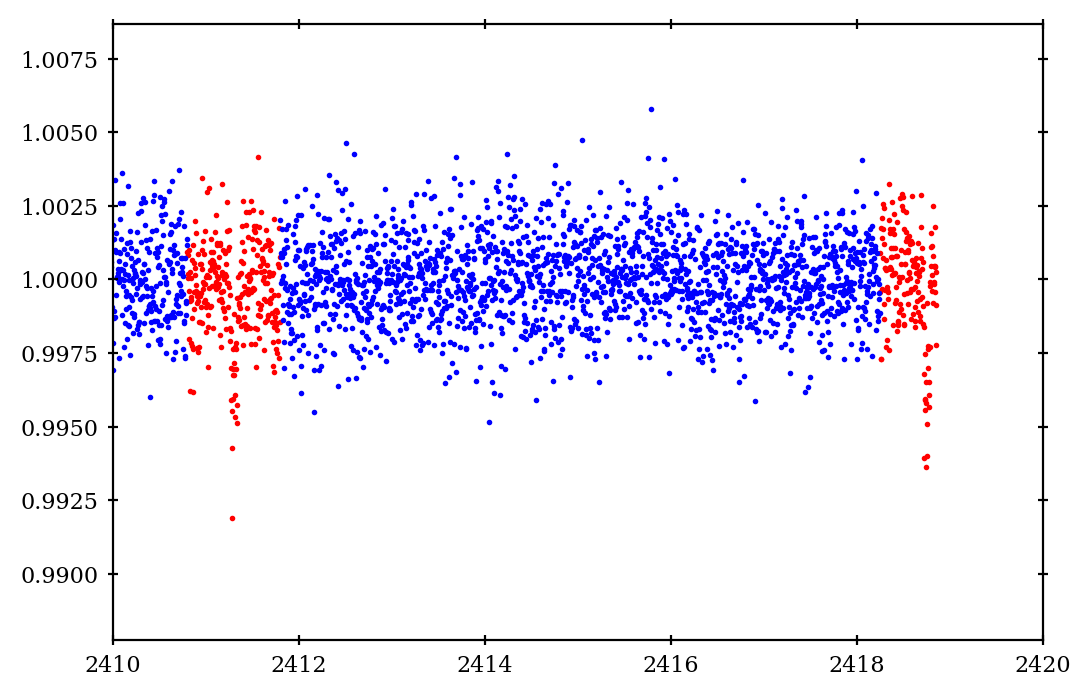

In [38]:
intransit_5min = transit_mask(time_5min, results.period, 1, results.T0)
intransit = transit_mask(time, results.period, 1, results.T0)

plt.scatter(time_5min[intransit_5min], flux_5min[intransit_5min], s=1, color='red')  # in-transit points in red
plt.scatter(time_5min[~intransit_5min], flux_5min[~intransit_5min], s=1, color='blue')  # other points in blue
plt.xlim(2410, 2420)

(0.0, 50.0)

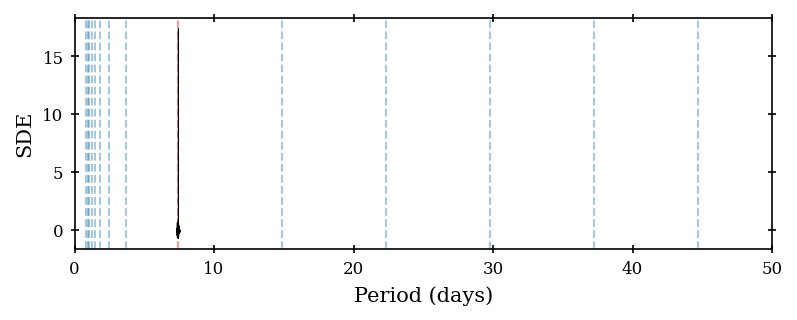

In [39]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)
plt.xlim(np.min(results.periods), np.max(results.periods))
ax.axvline(results.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))
plt.xlim(0, 50)
#plt.ylim(0, 100)

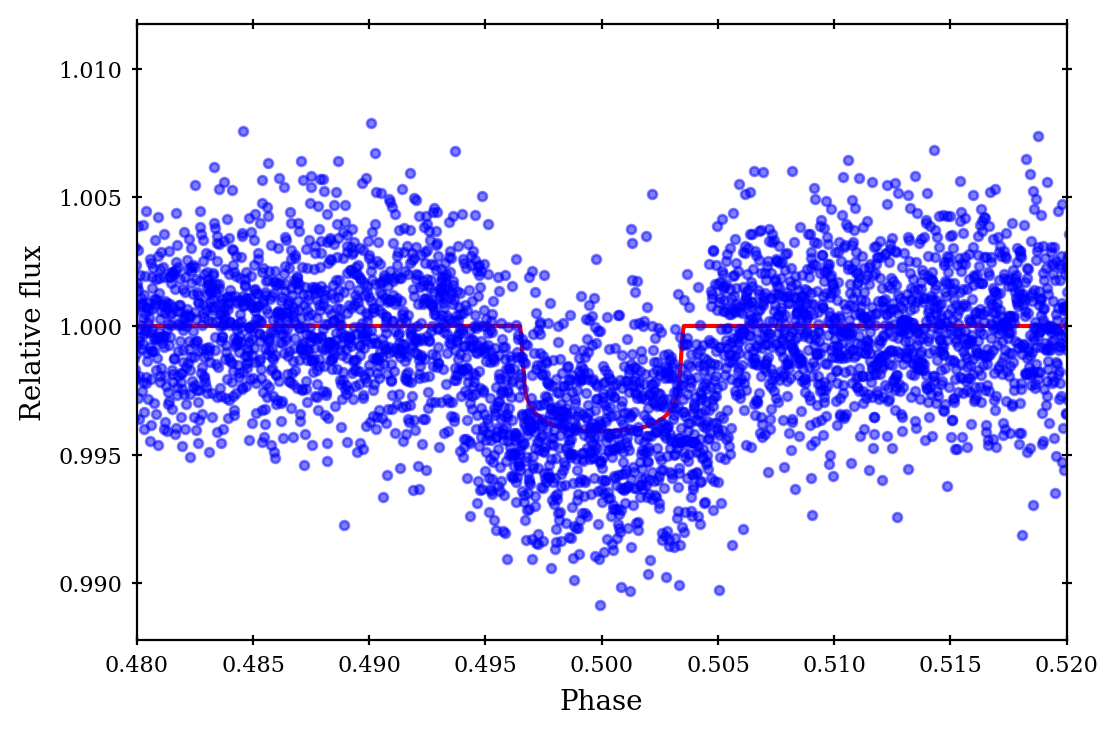

In [40]:
# results phase folded
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [41]:
results.duration*10

0.08845408127274046

In [42]:
duration_tess/24

0.08347140734040416+/-0.006621239583333332

(2418.0, 2420.0)

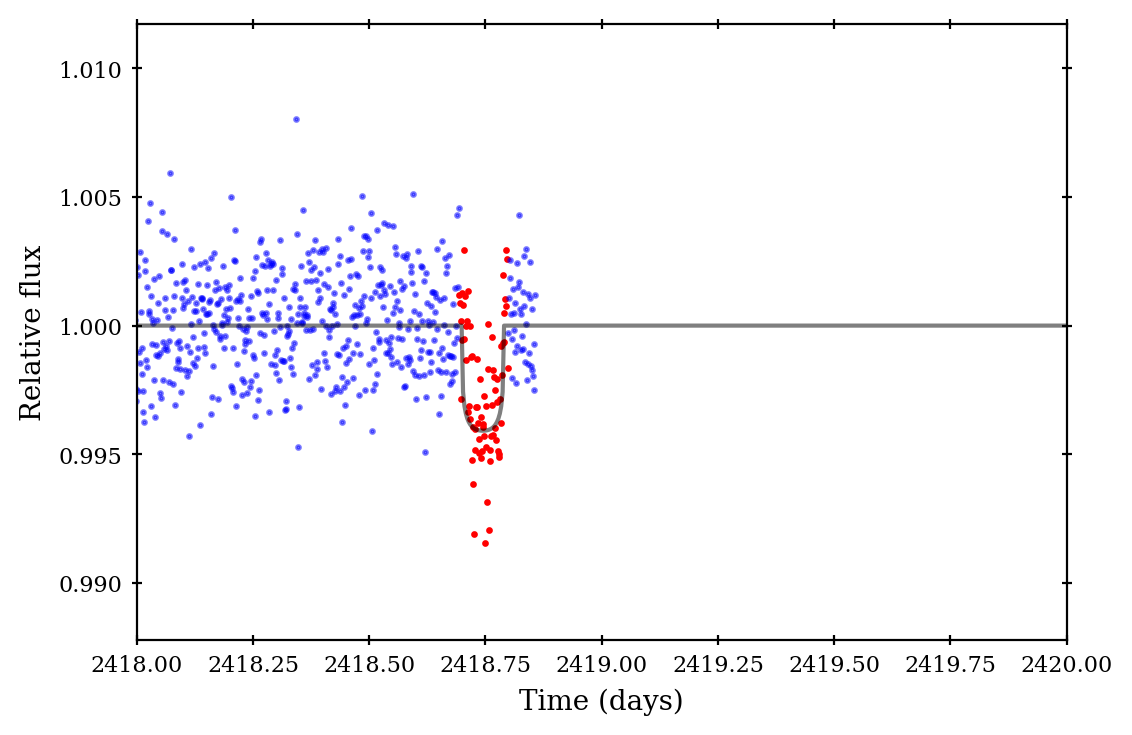

In [43]:
# complete light curve
plt.figure()
in_transit = transit_mask(tls_time, results.period, results.duration*12, results.T0)
plt.scatter(tls_time[in_transit], tls_flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(tls_time[~in_transit], tls_flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(tls_time.min(), tls_time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(2418,2420)

In [44]:
# # search for second planet
# tls_time_2 = tls_time[~in_transit]
# tls_flux_2 = tls_flux[~in_transit]
# tls_flux_err_2 = tls_flux_err[~in_transit]

# tls_2 = transitleastsquares(tls_time_2, tls_flux_2, tls_flux_err_2)
# results2 = tls_2.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
#                                                 M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
#                                                 period_min=0.5,
#                                                 period_max=(tls_time_2.max()-tls_time_2.min())/2,
#                                                 u=list(info[0]))

In [45]:
# print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)

In [46]:
# fig, ax = plt.subplots(figsize=(6,2), dpi=150)
# plt.xlim(np.min(results2.periods), np.max(results2.periods))
# ax.axvline(results2.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
# for n in range(2, 10):
#     ax.axvline(n*results2.period, alpha=0.4, lw=1, linestyle="dashed")
#     ax.axvline(results2.period / n, alpha=0.4, lw=1, linestyle="dashed")
# plt.ylabel(r'SDE')
# plt.xlabel('Period (days)')
# plt.plot(results2.periods, results2.power, color='black', lw=0.5)
# #plt.xlim(0, max(results2.periods))
# plt.xlim(0, 50)
# plt.ylim(-0.1, 1)

In [47]:
# # results phase folded
# plt.figure()
# plt.plot(results2.model_folded_phase, results2.model_folded_model, color='red')
# plt.scatter(results2.folded_phase, results2.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
# plt.xlim(0.48, 0.52)
# plt.xlabel('Phase')
# plt.ylabel('Relative flux');

In [48]:
# # complete light curve
# plt.figure()
# in_transit2 = transit_mask(tls_time_2, results2.period, 1.5*results2.duration, results2.T0)
# plt.scatter(tls_time_2[in_transit2], tls_flux_2[in_transit2], color='red', s=2, zorder=0)
# plt.scatter(tls_time_2[~in_transit2], tls_flux_2[~in_transit2], color='blue', alpha=0.5, s=2, zorder=0)
# plt.plot(results2.model_lightcurve_time, results2.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
# plt.xlim(tls_time_2.min(), tls_time_2.max())
# plt.xlabel('Time (days)')
# plt.ylabel('Relative flux');
# plt.xlim(2731,2732)

### GLS analysis

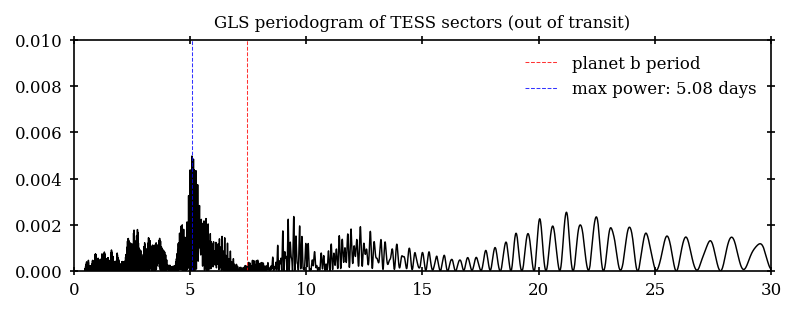

In [49]:
# first remove in-transit points
in_transit3 = transit_mask(time_short_all, results.period, 12*results.duration, results.T0)
lslc = ls(time_short_all[~in_transit3], flux_short_all[~in_transit3], flux_err_short_all[~in_transit3])

lc_freq, lc_power = lslc.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.7)
ax.set_xlim(0,30)
ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.5, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title('GLS periodogram of TESS sectors (out of transit)')
plt.savefig('./plots/toi4438/gls-toi4438.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

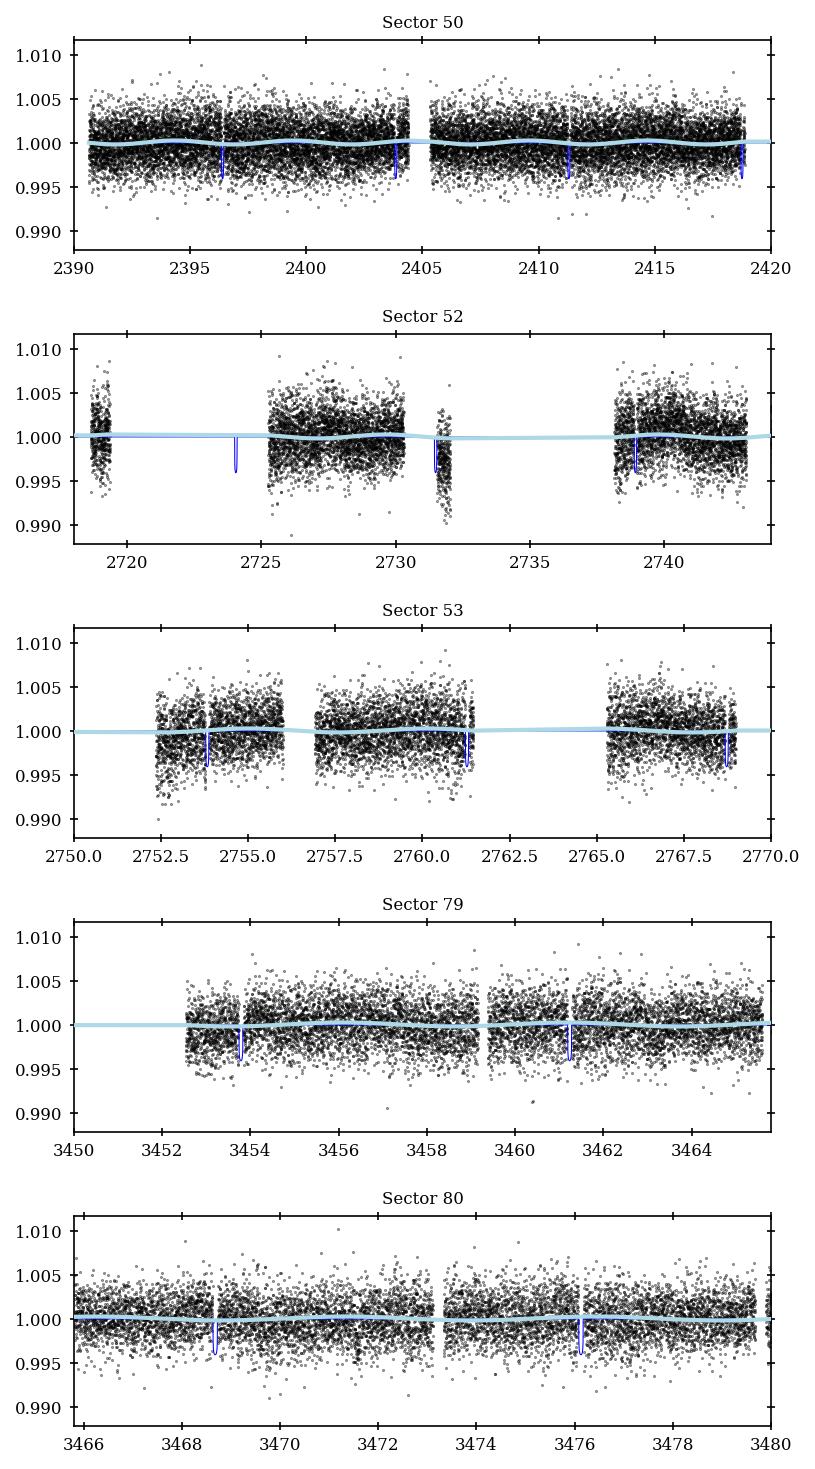

In [50]:
y_fit = lslc.model(time_short_all[~in_transit3], lc_freq[np.argmax(lc_power)])
fig, ax = plt.subplots(5, 1, figsize=(6,12), dpi=150)
fig.subplots_adjust(hspace=0.4)
ax[0].plot(time_short_all[~in_transit3], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[0].set_xlim(2390,2420)
ax[0].scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
ax[0].set_title('Sector 50')
ax[0].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)

ax[1].plot(time_short_all[~in_transit3], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[1].set_xlim(2718,2744)
ax[1].scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
ax[1].set_title('Sector 52')
ax[1].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)

ax[2].plot(time_short_all[~in_transit3], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[2].set_xlim(2750, 2770)
ax[2].scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
ax[2].set_title('Sector 53')
ax[2].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)

ax[3].plot(time_short_all[~in_transit3], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[3].set_xlim(3450,3465.8)
ax[3].scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
ax[3].set_title('Sector 79')
ax[3].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)

ax[4].plot(time_short_all[~in_transit3], y_fit, color='lightblue', linewidth=2, zorder=1000)
ax[4].set_xlim(3465.8,3480)
ax[4].scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
ax[4].set_title('Sector 80')
ax[4].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)


plt.savefig('./plots/toi4438/gls-toi4438-modulation.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [51]:
# compare rms of residuals and rms of data
rms_data = np.std(flux_short_all[~in_transit3])
rms_res = np.std(flux_short_all[~in_transit3] - y_fit)
print(rms_data*1e3, rms_res*1e3)

2.2858988404949945 2.2797781292453134


## Modelo Global

#### Model variables

In [52]:
def get_xy(time, version='short'):
    # parametros
    # ----------
    # time: '120', '300' (int)
    # devuelve
    # ----------
    # x, y, yerr, texp (en días y ppt)
    if version == 'all':
        if time == 120:
            t = time
            flux = flux
            flux_err = flux_err
            texp = texp_short
            id = sector_id
        elif time == 300:
            t = time_5min
            flux = flux_5min
            flux_err = flux_err_5min
            texp = texp_binned
            id = sector_id_5min
    elif version == 'short':
        if time == 120:
            t = time[intransit]
            flux = flux[intransit]
            flux_err = flux_err[intransit]
            texp = texp_short
            id = sector_id[intransit]
        elif time == 300:
            t = time_5min[intransit_5min]
            flux = flux_5min[intransit_5min]
            flux_err = flux_err_5min[intransit_5min]
            texp = texp_binned
            id = sector_id_5min[intransit_5min]

    x = np.ascontiguousarray(t - ref_time, dtype=np.float64)
    y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
    yerr = np.ascontiguousarray(1e3 * flux_err, dtype=np.float64) 
    return x, y, yerr, texp, id

In [53]:
# lc para modelo
x, y, yerr, texp, id = get_xy(300, 'short')

# rvs
# x_rv, y_rv, yerr_rv, rv_inst_id
x_rv = x_rv - ref_time

In [54]:
len(x)

4364

### Keep only 1 day arround transits

In [55]:
K_est = xo.estimate_semi_amplitude(results.period, x_rv, y_rv, yerr_rv, t0s=results.T0-ref_time)
print(K_est, "m/s")

[3.34913503] m/s


### GP in LC and RV

In [56]:
# # version with GP in RV and LC 
# # I should CHECK THE MEAN OFFSET OF THE MODEL PER INSTRUMENT, IT'S NOT IMPLEMENTED HERE

# phase_lc = np.linspace(-0.3, 0.3, 100)
# t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1500)

# with pm.Model() as model:
#     # Parameters for the stellar properties
#     lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)
#     u_star = xo.QuadLimbDark("u_star")
#     star = xo.LimbDarkLightCurve(u_star)

#     # Stellar parameters from TESS
#     mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
#     rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

#     # Orbital parameters for the planet
#     t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=1.0)
#     logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
#     P = pm.Deterministic("P", pt.exp(logP))
#     K = pm.Uniform("K", lower=0, upper=10)

#     # Fit in terms of ror
#     log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-results.depth)), sigma=1)
#     ror = pm.Deterministic("ror", pt.exp(log_ror))
#     r_pl = pm.Deterministic("r_pl", ror * rstar)
#     b = xo.ImpactParameter('b', ror)
 
#     h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
#     ecc = pm.Deterministic("e", h**2 + k**2)
#     omega = pm.Deterministic("w", pt.arctan2(k, h))

#     # derived parameters
#     m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
#     density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
#     a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
#     teq = pm.Deterministic('teq', pub_teff.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
   
#     # LC jitter & GP parameters
#     log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sigma=10)
#     log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
#     log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sigma=10)

#     # RV noise & GP parameters
#     log_sigma_gp_rv = pm.Normal("log_sigma_gp_rv", mu=np.log(np.std(y_rv)), sigma=10)
#     log_rho_gp_rv = pm.Normal("log_rho_gp_rv", mu=np.log(50), sigma=50)
#     #log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.std(y_rv)), sigma=10)

#     # Orbit model
#     orbit = xo.orbits.KeplerianOrbit(
#             r_star=rstar,
#             m_star=mstar,
#             period=P,
#             t0=t0,
#             b=b,
#             ecc=ecc,
#             omega=omega,
#         )
    
#     # Compute the model light curve
#     light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp_short)* 1e3)
#     light_curve = pm.math.sum(light_curves, axis=-1) + lc_mean

#     # GP model for the light curve
#     kernel = terms.SHOTerm(
#             sigma=pt.exp(log_sigma_gp),
#             rho=pt.exp(log_rho_gp),
#             Q=1 / np.sqrt(2),)
    
#     gp_lc = GaussianProcess(kernel, t=x, mean=light_curve, yerr=pt.exp(log_sigma_lc))
#     gp_lc.marginal("obs_lc", observed=y)

#     # Compute and save the phased light curve models
#     pm.Deterministic("lc_pred", 1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp_short)[..., 0],)
#     pm.Deterministic("gp_lc_pred", gp_lc.predict(y, include_mean=False))

#     # RVs
#     # Per instrument parameters
#     sigmas = pm.HalfNormal("sigmas", sigma=10, shape=len(rv_inst_names))

#     # Compute the RV offset and jitter for each data point depending on its instrument
#     diag = pt.zeros(len(x_rv))
#     for i in range(len(rv_inst_names)):
#         diag += (yerr_rv**2 + sigmas[i] ** 2) * (rv_inst_id == i)
#     pm.Deterministic("rv_mean", rv_mean)
#     pm.Deterministic("diag", diag)

#     def get_rv_model(x, name=""):
#         vrad = orbit.get_radial_velocity(x, K=K)
#         pm.Deterministic("vrad" + name, vrad)
#         return pm.Deterministic("rv_model" + name, vrad)
    
#     rv_model = get_rv_model(x_rv)
#     get_rv_model(t_rv, "_pred")

#     kernelrv = terms.SHOTerm(
#         sigma=pt.exp(log_sigma_gp_rv), 
#         rho=pt.exp(log_rho_gp_rv), 
#         Q=1.0 / 3)
    
#     gp_rv = GaussianProcess(kernelrv, t=x_rv, mean=rv_model, diag=diag)
#     gp_rv.marginal("obs_rv", observed=y_rv)
#     pm.Deterministic("gp_rv_pred", gp_rv.predict(y_rv, include_mean=True))

#     map_params = pm.find_MAP()
#     map_soln = pmx.optimize(start=map_params)

#     extras = dict(zip(["light_curves"], pmx.eval_in_model(
#             [light_curves], map_soln)))

#### LC map plot

In [57]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
# gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# # first plot the gp model
# ax = axes[0]
# ax.plot(x, y, "k", label="data")
# ax.plot(x, gp_only, color="C2", label="gp model")
# ax.legend(fontsize=10)
# ax.set_ylabel("relative flux [ppt]")

# # then detrend data for gp model and plot the lc model
# ax = axes[1]
# ax.plot(x, y - gp_only, "k", label="de-trended data")
# ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
# ax.legend(fontsize=10, loc=3)
# ax.set_ylabel("de-trended flux [ppt]")

# # residuals of gp + lc model
# ax = axes[2]
# ax.plot(x, y - lc_mod - gp_only, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]")
# ax.set_xlim(x.min(), x.max())
# ax.set_xlabel("time [days]")
# plt.xlim(345, 360)

# #plt.savefig('toi4438_lc.png', dpi=300)

#### RV map plot

In [58]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

# lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
# gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# # first plot the gp model
# ax = axes[0]
# ax.plot(x, y, "k", label="data")
# ax.plot(x, gp_only, color="C2", label="gp model")
# ax.legend(fontsize=10)
# ax.set_ylabel("relative flux [ppt]")

# # then detrend data for gp model and plot the lc model
# ax = axes[1]
# ax.plot(x, y - gp_only, "k", label="de-trended data")
# ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
# ax.legend(fontsize=10, loc=3)
# ax.set_ylabel("de-trended flux [ppt]")

# # residuals of gp + lc model
# ax = axes[2]
# ax.plot(x, y - lc_mod - gp_only, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]")
# ax.set_xlim(x.min(), x.max())
# ax.set_xlabel("time [days]")
# plt.xlim(345, 360)

# #plt.savefig('toi4438_lc.png', dpi=300)

### GP in LC, constant background in RV

In [59]:
# version with GP in LC, offset in RV
phase_lc = np.linspace(-0.3, 0.3, 100)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1500)

with pm.Model() as model:
    # Parameters for the stellar properties
    #lc_means = pm.Normal("lc_mean", mu=0.0, sigma=1.0)
    u_star = xo.QuadLimbDark("u_star")
    star = xo.LimbDarkLightCurve(u_star)

    # Stellar parameters from TESS
    mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
    rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

    # Orbital parameters for the planet
    t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=1.0)
    logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
    P = pm.Deterministic("P", pt.exp(logP))
    K = pm.Uniform("K", lower=0, upper=10)

    # Fit in terms of ror
    log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-results.depth)), sigma=1)
    ror = pm.Deterministic("ror", pt.exp(log_ror))
    r_pl = pm.Deterministic("r_pl", ror * rstar)
    b = xo.ImpactParameter('b', ror)
 
    h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
    ecc = pm.Deterministic("e", h**2 + k**2)
    omega = pm.Deterministic("w", pt.arctan2(k, h))

    # derived parameters
    m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth))
    density_pl = pm.Deterministic('density_pl', m_pl*u.M_earth.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
    a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl*u.M_earth.to(u.kg))/(4*np.pi**2))**(1/3)*u.m.to(u.au))
    teq = pm.Deterministic('teq', pub_teff.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
   
    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
            r_star=rstar,
            m_star=mstar,
            period=P,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
    
    lc_models = dict()
    # Function to compute he light curve model
    def lc_model(mean, star, r_pl, texp, t):
        return pt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean

    # divide the LC data in three sectors
    for i, name in enumerate(sector_id_names):
        with pm.Model(name=name, model=model):
            # a mean for each sector
            lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)

            # LC jitter & GP parameters
            log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y[id == i])), sigma=10)
            log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
            log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y[id == i])), sigma=10)

        # compute the model light curve
        lc_models[name] = lc_model(lc_mean, star, r_pl, texp, x[id == i])
        # Compute and save the light curve models
        pm.Deterministic(f"{name}_lc", lc_models[name])

        kernel = terms.SHOTerm(
            sigma=pt.exp(log_sigma_gp),
            rho=pt.exp(log_rho_gp),
            Q=1 / np.sqrt(2))
        
        gp_lc = GaussianProcess(kernel, t=x[id == i], mean=lc_models[name], yerr=pt.exp(log_sigma_lc))
        gp_lc.marginal(f"{name}_obs_lc", observed=y[id == i])
        pm.Deterministic(f"{name}_gp_lc_pred", gp_lc.predict(y[id == i], include_mean=False))
    
    # Function for computing the full RV model
    def get_rv_model(x, name=""):
        vrad = orbit.get_radial_velocity(x, K=K)
        pm.Deterministic("vrad" + name, vrad)
        return pm.Deterministic("rv_model" + name, vrad)

    # Loop over the instruments
    parameters = dict()
    rv_models = dict()

    # Per instrument offset and jitter
    means = pm.Normal("means", mu=np.array([np.median(y_rv[rv_inst_id == i]) for i in range(len(rv_inst_names))]), sigma=5, shape=len(rv_inst_names))
    log_sigmas_rv = pm.Normal("log_sigmas_rv", mu=np.log(np.array([(np.median(yerr_rv[rv_inst_id == i])) for i in range(len(rv_inst_names))])), sigma=1)

    mean = pt.zeros(len(x_rv))
    sigma = pt.zeros(len(x_rv))
    for i in range(len(rv_inst_names)):
        mean += means[i] * (rv_inst_id == i)
        sigma += (yerr_rv**2 + pt.exp(2 * log_sigmas_rv[i]) * (rv_inst_id == i))

    pm.Deterministic("mean", mean)
    pm.Deterministic("sigma", sigma)

    # rv model
    rv_model = get_rv_model(x_rv) + mean
    get_rv_model(t_rv, "_pred")

    # the likelihood for the rvs
    err = pt.sqrt(sigma)
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y_rv)

    # Find MAP
    map_params = pm.find_MAP()
    map_soln = pmx.optimize(start=map_params)

/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/home/juanserrano/anaconda3/envs/exoplanet2/

Output()

Output()

#### LC map plot

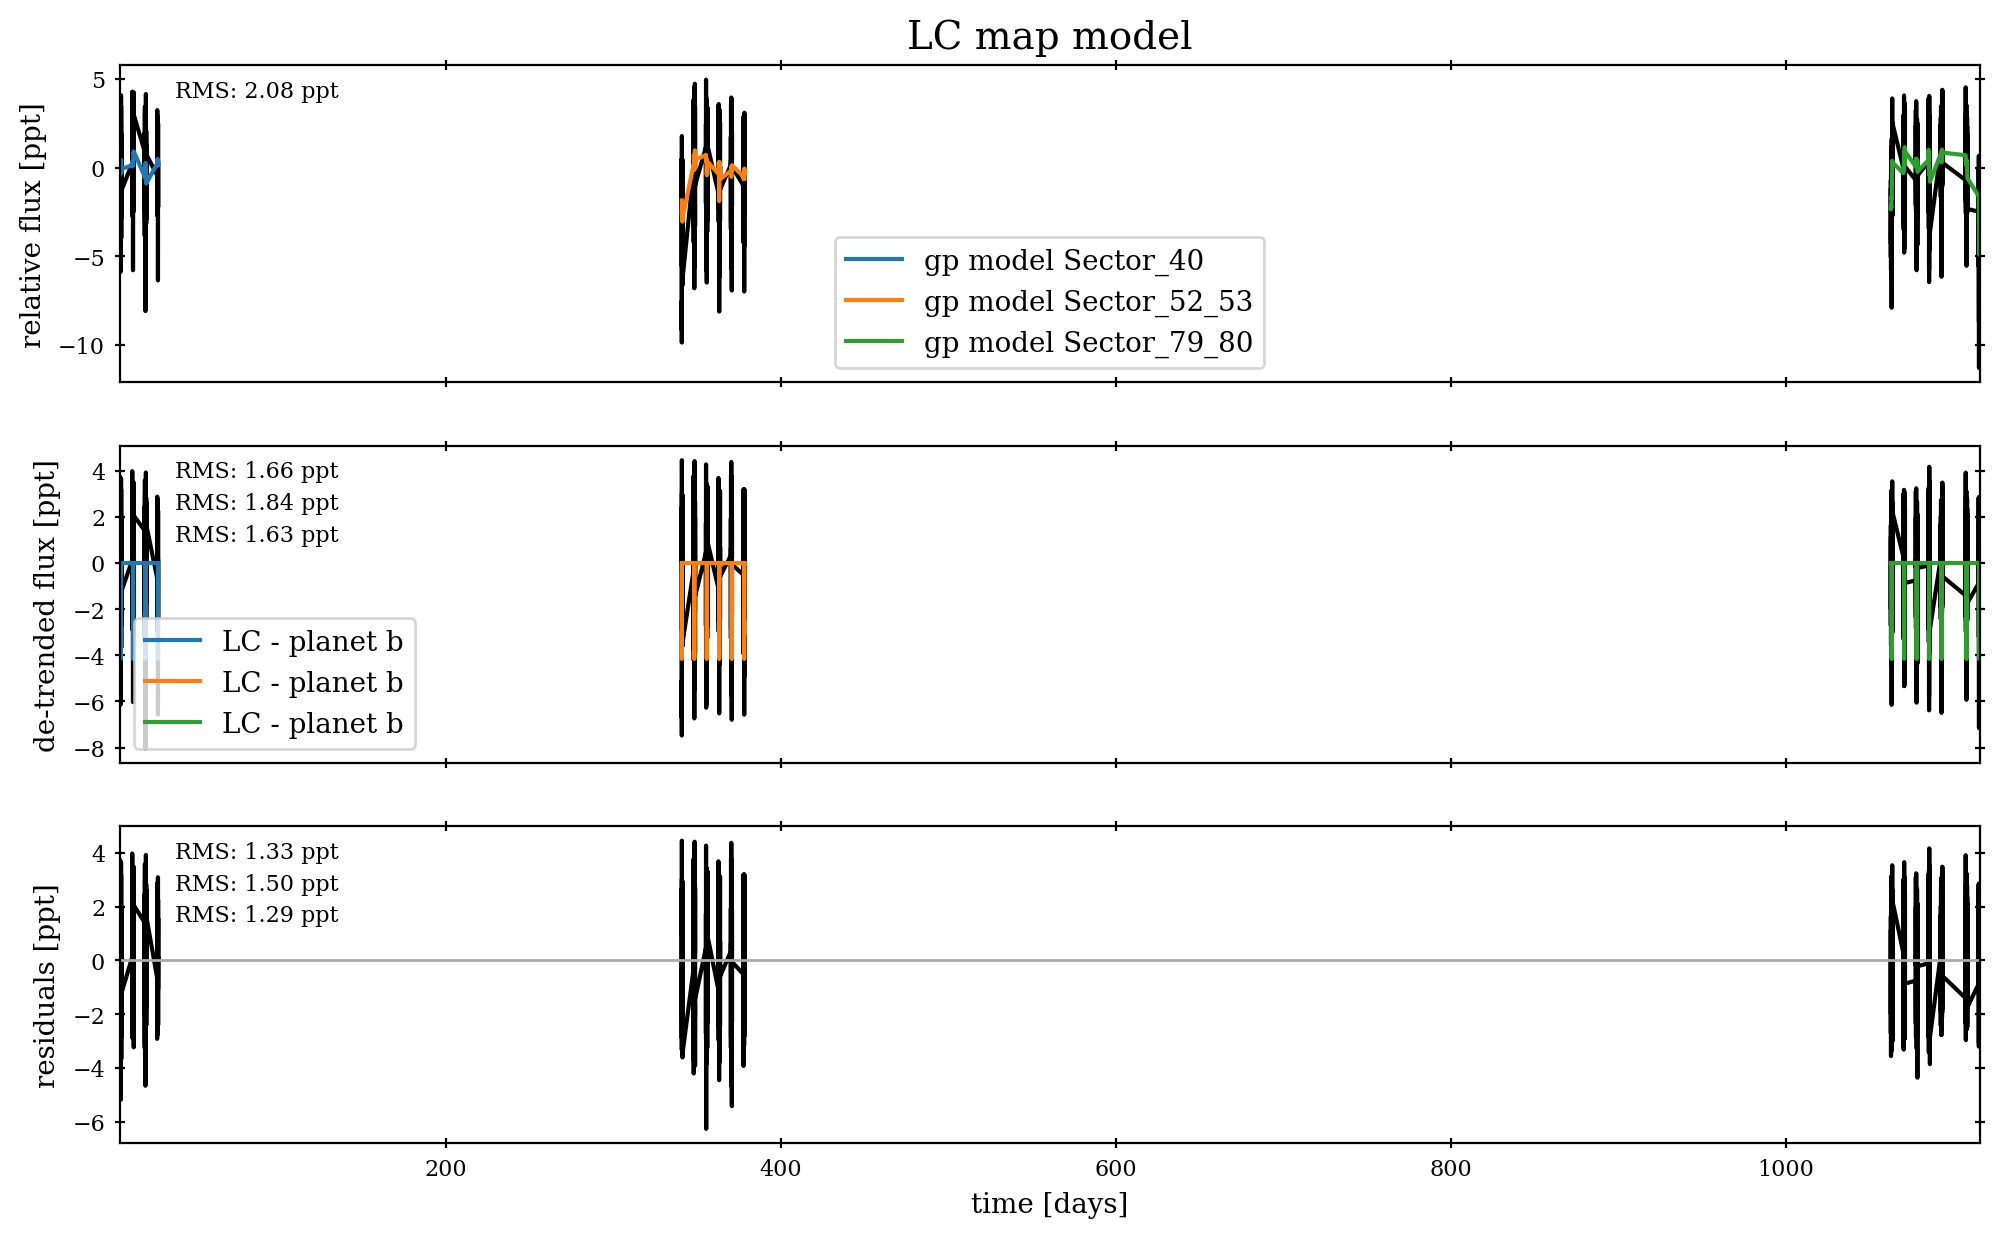

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"] # gp model (on top of lc + mean)
    # first plot the lc model with GP
    ax.plot(x[id == i], y[id == i], "k")
    ax.plot(x[id == i], gp, label="gp model {}".format(name))
ax.text(x=0.03, y=0.9, s=f'RMS: {np.std(y):.2f} ppt', transform=ax.transAxes)
ax.legend(fontsize=10)
ax.set_ylabel("relative flux [ppt]")
ax.set_title('LC map model', fontsize=14)

# then detrend data for gp model and plot the lc model
ax = axes[1]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"]
    gp_only = gp - lc_mod
    ax.plot(x[id == i], y[id == i] - gp, "k")
    ax.plot(x[id == i], lc_mod, label="LC - planet {0}".format(b))
    ax.text(x=0.03, y=0.9-i/10, s=f'RMS: {np.std(y[id == i] - gp):.2f} ppt', transform=ax.transAxes)
ax.legend(fontsize=10, loc=3)
ax.set_ylabel("de-trended flux [ppt]")

# residuals of gp + lc model
ax = axes[2]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"]
    ax.plot(x[id == i], y[id == i] - gp - lc_mod, "k")
    ax.text(x=0.03, y=0.9-i/10, s=f'RMS: {np.std(y[id == i] - gp - lc_mod):.2f} ppt', transform=ax.transAxes)
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("residuals [ppt]")
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("time [days]")
#plt.xlim(345, 360)

#plt.savefig('./plots/toi4438/toi4438_map_lc.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
#plt.savefig('toi4438_lc.png', dpi=300)
plt.show()

#### RV map plot

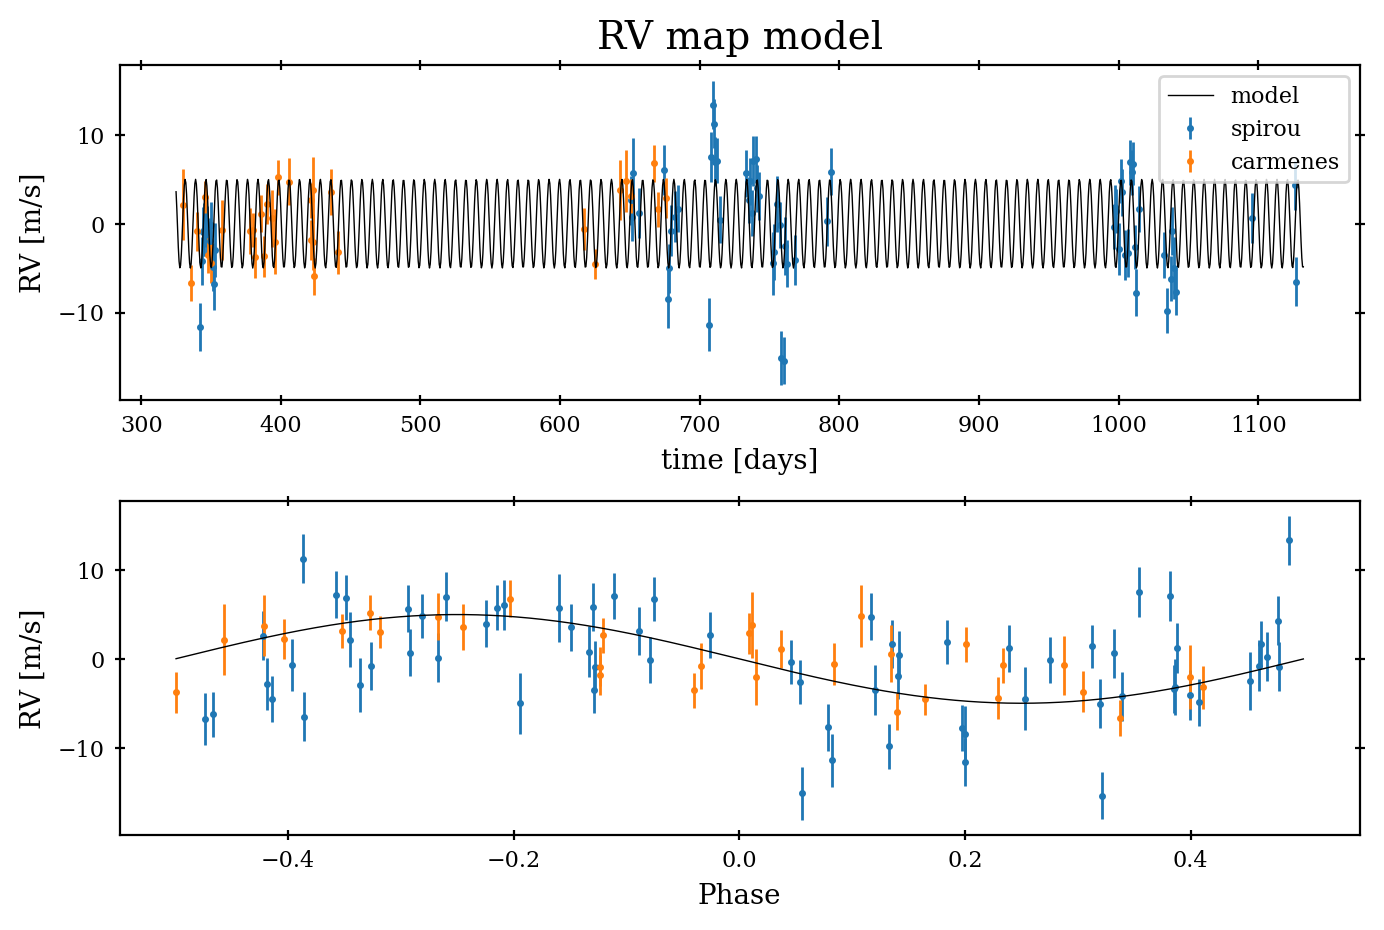

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharey=True)
fig.subplots_adjust(hspace=0.3)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], y_rv[m] - map_soln["mean"][m], yerr=yerr_rv[m], fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
ax[0].plot(t_rv, map_soln["rv_model_pred"], lw=0.5, color="k", label="model")
ax[0].set_ylabel("RV [m/s]")
ax[0].set_xlabel("time [days]")
ax[0].legend(fontsize=8, loc='upper right', frameon=True)
ax[0].set_title('RV map model', fontsize=14)

folded = (x_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds = np.argsort(folded)
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    xfold = (x_rv[m] - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
    inds = np.argsort(xfold)
    ax[1].errorbar(xfold[inds]/map_soln["P"], y_rv[m][inds] - map_soln["mean"][m], yerr=yerr_rv[m][inds], fmt=".",
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
folded_t = (t_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds2 = np.argsort(folded_t)
ax[1].plot(folded_t[inds2]/map_soln["P"], map_soln["rv_model_pred"][inds2], "k", lw=0.5)
ax[1].set_ylabel("RV [m/s]")
ax[1].set_xlabel("Phase")
plt.savefig('./plots/toi4438/toi4438_map_rv.png', dpi=200, bbox_inches='tight', pad_inches=0.1)


### GP in LC, quadratic drift in RV

### Posterior Sampling

In [62]:
with model:
    trace = pm.sample(
        draws=500,
        tune=500,
        initvals=map_soln,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/juanserrano/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [__u_star_q1, __u_star_q2, mstar, rstar, t0, logP, K, log_ror, __b_impact_parameter, h, __k_unit_disk, Sector_40::lc_mean, Sector_40::log_sigma_lc, Sector_40::log_rho_gp, Sector_40::log_sigma_gp, Sector_52_53::lc_mean, Sector_52_53::log_sigma_lc, Sector_52_53::log_rho_gp, Sector_52_53::log_sigma_gp, Sector_79_80::lc_mean, Sector_79_80::log_sigma_lc, Sector_79_80::log_rho_gp, Sector_79_80::log_sigma_gp, means, log_sigmas_rv]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 523 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [63]:
# # trace to save
az.to_netcdf(trace, 'trace.global4438_gp_persector.save')

# # save to trace
# trace = az.from_netcdf('trace.global4438.save')

'trace.global4438_gp_persector.save'

In [65]:

summary = az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                     var_names=[
                         "t0",
                         "P",
                         "K",
                         "b",
                         "m_pl",
                         "density_pl",
                         "a",
                         "teq",
                         "e",
                         "ror",
                         "r_pl",
                         "rstar",
                         "mstar",
                         "u_star",
                         "w",
                        #  "log_rho_gp",
                        #  "log_rho_gp_rv",
                        #  "log_sigma_gp",
                        #  "log_sigma_gp_rv",
                     ])
summary

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.753750,0.000643,5.751921,5.755872,0.000017,0.000012,1438.298182,763.015917,1.005082,5.753742,0.000642
P,7.446297,0.000006,7.446278,7.446313,0.000000,0.000000,1639.033013,827.265061,1.000071,7.446297,0.000006
K,3.294792,0.600416,1.507656,4.882983,0.013958,0.009872,1864.450780,758.537717,0.998919,3.305404,0.600116
b,0.228109,0.149968,0.000643,0.626785,0.008760,0.006201,254.940171,240.526597,1.000709,0.217322,0.149893
m_pl,5.059927,0.925943,2.547583,7.717725,0.021897,0.015486,1792.812301,770.265659,0.999174,5.077941,0.925480
density_pl,1.841693,0.384329,0.910755,3.159716,0.009674,0.006841,1523.482031,717.835599,0.999763,1.826001,0.384137
a,0.053050,0.000961,0.050126,0.055819,0.000027,0.000019,1251.605634,946.075153,1.001267,0.053040,0.000960
teq,440.894042,6.983429,420.635143,462.267355,0.215820,0.152873,1049.958435,845.156000,1.003345,440.818594,6.979937
e,0.074229,0.058119,0.000108,0.294241,0.002289,0.001619,683.668786,746.488071,1.001292,0.060016,0.058090
ror,0.059955,0.001185,0.056983,0.063359,0.000064,0.000045,338.473632,499.065333,1.000053,0.059908,0.001185


### Resulting parameters

In [67]:
import math
from uncertainties import ufloat
from uncertainties.umath import *
from asymmetric_uncertainty import a_u

params = {}
for var in list(trace.posterior.data_vars):
    parameter = a_u(trace.posterior[var].median().item(), 
             trace.posterior[var].quantile(q=0.84).item()-trace.posterior[var].median().item(), 
             trace.posterior[var].median().item()-trace.posterior[var].quantile(q=0.16).item())
    print(var, " = {r:.3f}".format(r=parameter))
    params[var] = parameter

K  = 3.305 (+0.575, -0.645)
P  = 7.446 (+0.000, -0.000)
Sector_40::lc_mean  = 0.169 (+0.094, -0.137)
Sector_40::log_rho_gp  = 0.498 (+1.141, -1.905)
Sector_40::log_sigma_gp  = -1.194 (+0.479, -0.733)
Sector_40::log_sigma_lc  = 0.310 (+0.022, -0.025)
Sector_40_gp_lc_pred  = 0.024 (+0.252, -0.182)
Sector_40_lc  = 0.157 (+0.103, -0.210)
Sector_52_53::lc_mean  = -0.318 (+0.331, -0.329)
Sector_52_53::log_rho_gp  = 1.390 (+1.445, -1.196)
Sector_52_53::log_sigma_gp  = 0.017 (+0.377, -0.248)
Sector_52_53::log_sigma_lc  = 0.434 (+0.022, -0.017)
Sector_52_53_gp_lc_pred  = 0.208 (+0.560, -0.696)
Sector_52_53_lc  = -0.362 (+0.348, -0.533)
Sector_79_80::lc_mean  = -0.192 (+0.375, -0.378)
Sector_79_80::log_rho_gp  = 0.762 (+0.220, -0.196)
Sector_79_80::log_sigma_gp  = 0.284 (+0.222, -0.176)
Sector_79_80::log_sigma_lc  = 0.272 (+0.017, -0.017)
Sector_79_80_gp_lc_pred  = 0.407 (+0.600, -1.710)
Sector_79_80_lc  = -0.230 (+0.388, -0.503)
__b_impact_parameter  = 0.205 (+0.169, -0.148)
__k_unit_disk  = -0

In [69]:
# GP timescale on LC, derived from log_rho_gp
# 0.48 days (+0.04, -0.04)
timescale = np.exp(params['Sector_40::log_rho_gp'])/(np.sqrt(2)*np.pi)
timescale

### Cornerplot

In [70]:
CORNER_KWARGS = dict(
    smooth=0.5,
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

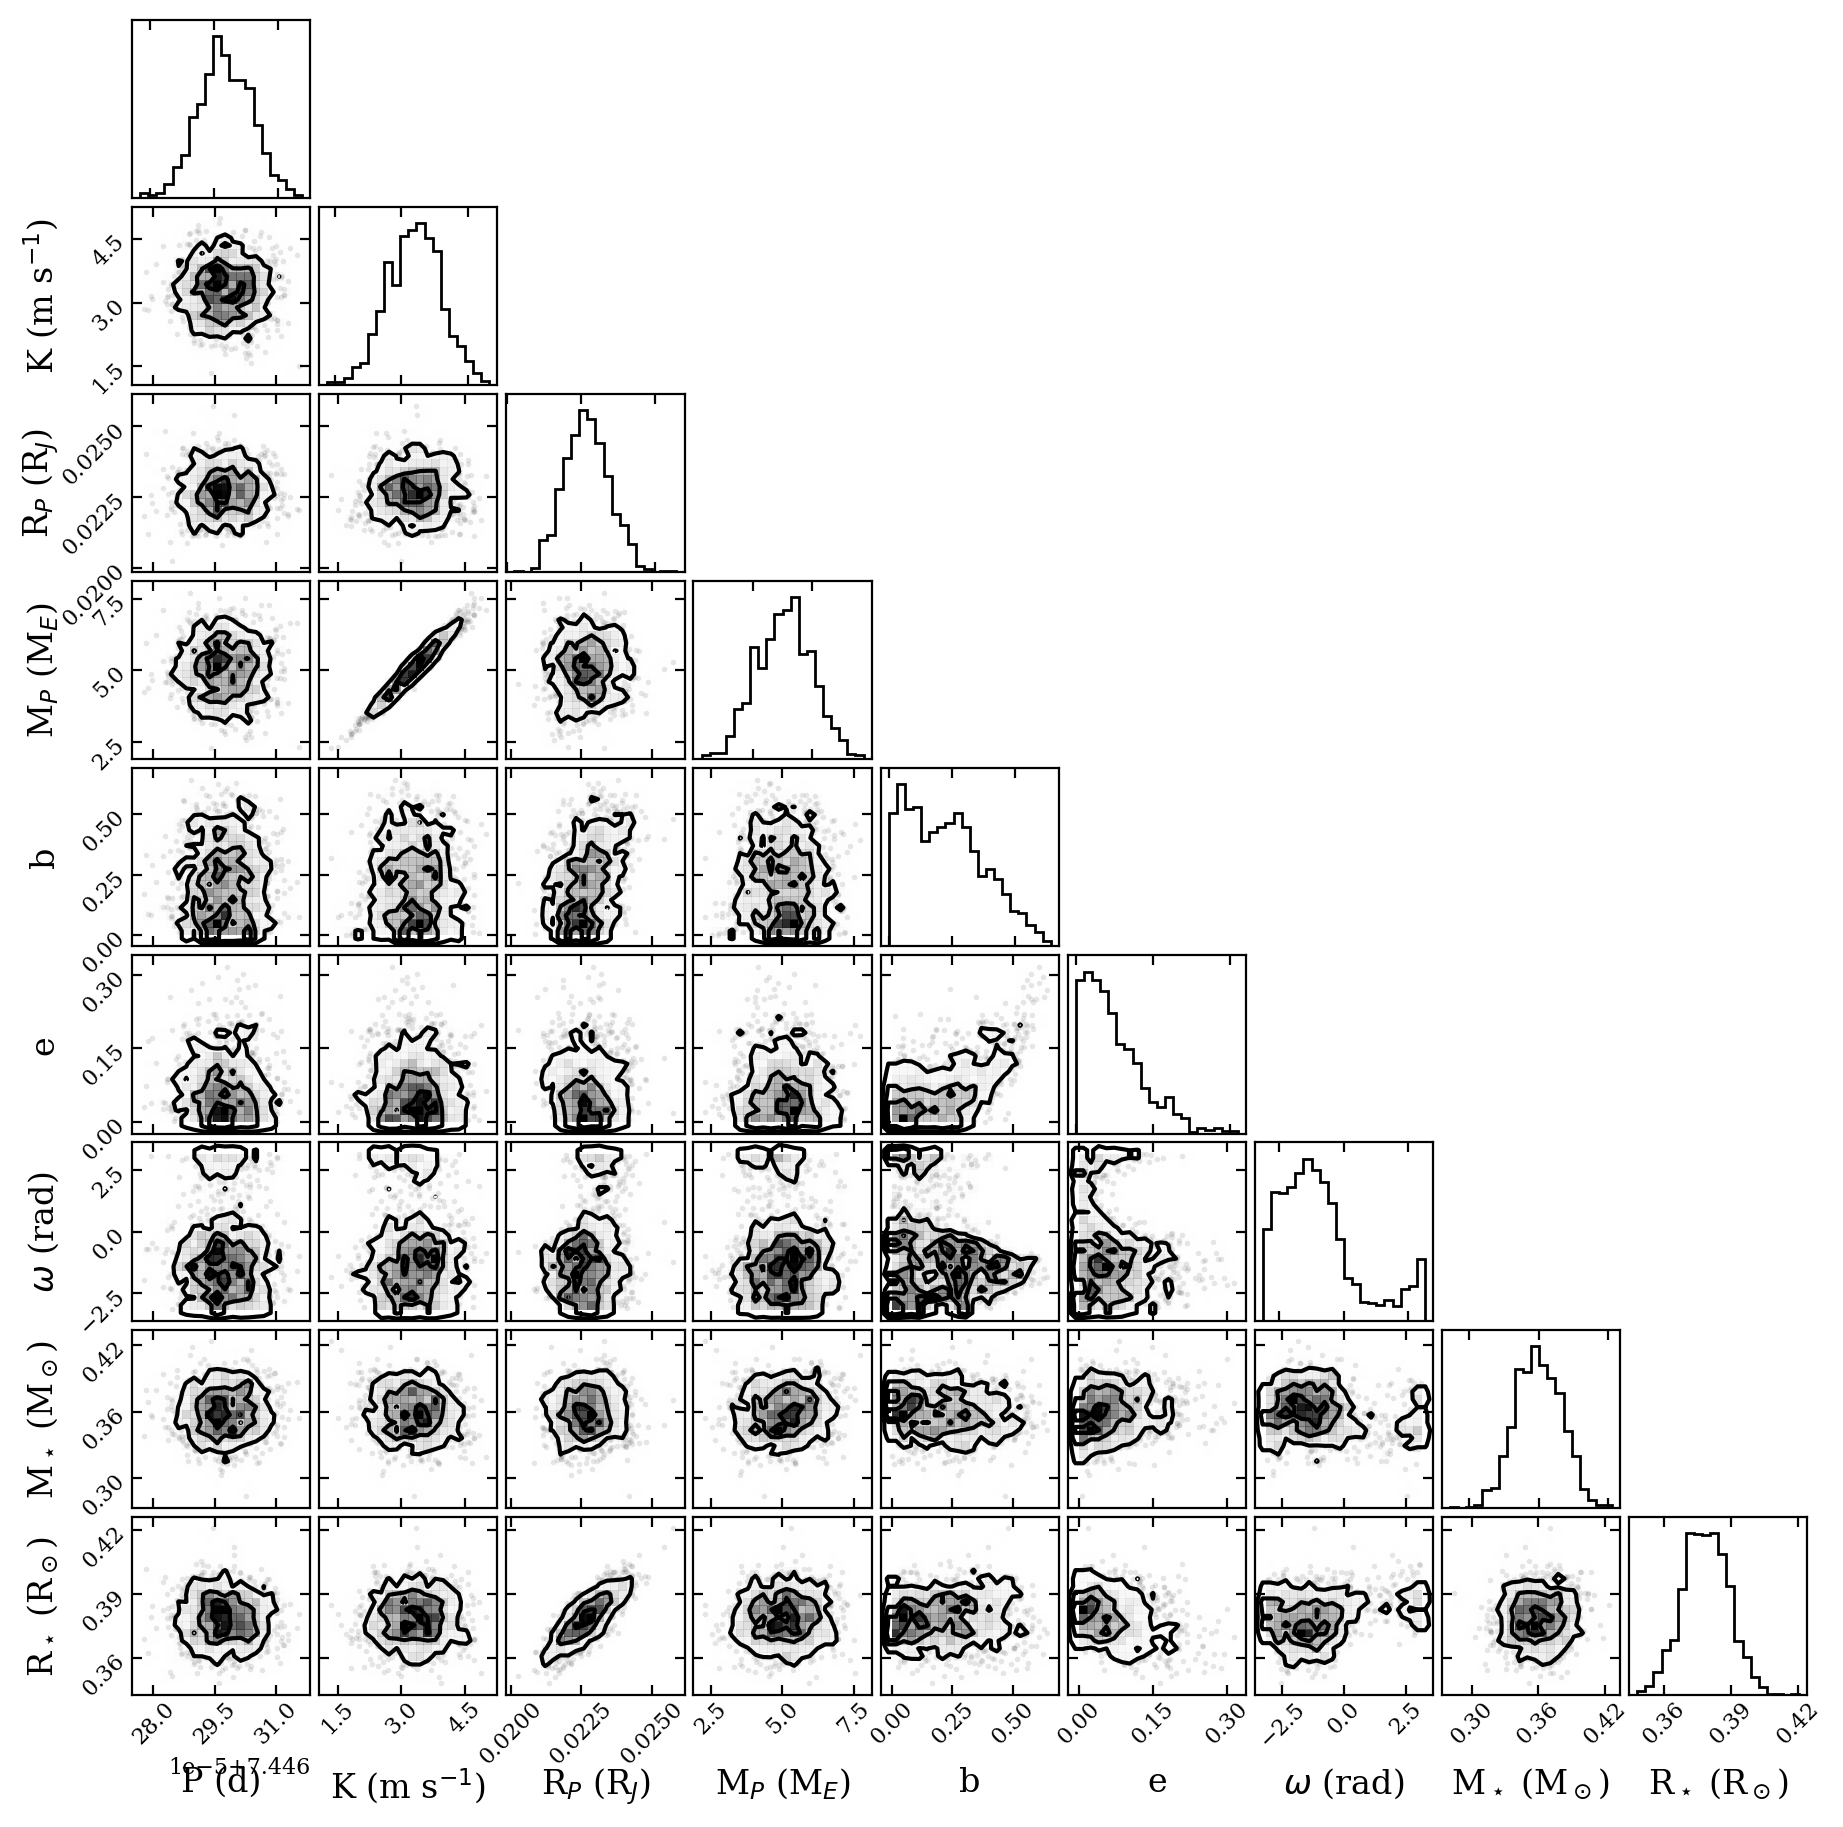

In [77]:
from cProfile import label
import corner
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()

fig, ax = plt.subplots(9, 9, figsize=(9, 9))

figure = corner.corner(trace, var_names=['P', 'K', 'r_pl', 'm_pl', 'b', 'e', 'w', 'mstar', 'rstar'],
                        labels=["P (d)", "K (m s$^{-1}$)", "R$_P$ (R$_J$)", "M$_P$ (M$_E$)", "b", "e", "$\omega~$(rad)","M$_\star$ (M$_\odot$)","R$_\star$ (R$_\odot$)"], label_kwargs={'fontsize':12},
                        show_titles=False, title_kwargs={'fontsize':12, 'pad':9.0}, titles=['P', 'K', 'R\_P','M\_P','b','e','$\omega$','M\_$\star$','R\_$\star$'], divergences=False, plot_contours=True,
                        labelpad=0.1, color='k', fig=fig, **CORNER_KWARGS)
for i,ax in enumerate(figure.get_axes()):
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
    #ax.ticklabel_format(axis='both', style='plain', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
    # if i == 71 or i == 72 or i == 73:
    #     ax.xaxis.set_major_formatter(formatter)

plt.savefig('./plots/toi4438/corner_toi4438.png', dpi=100, bbox_inches='tight', facecolor='w')
plt.show()

### RV fit plots

In [78]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

In [96]:
flat_samps['sigma'].median().values

array(24.40765448)

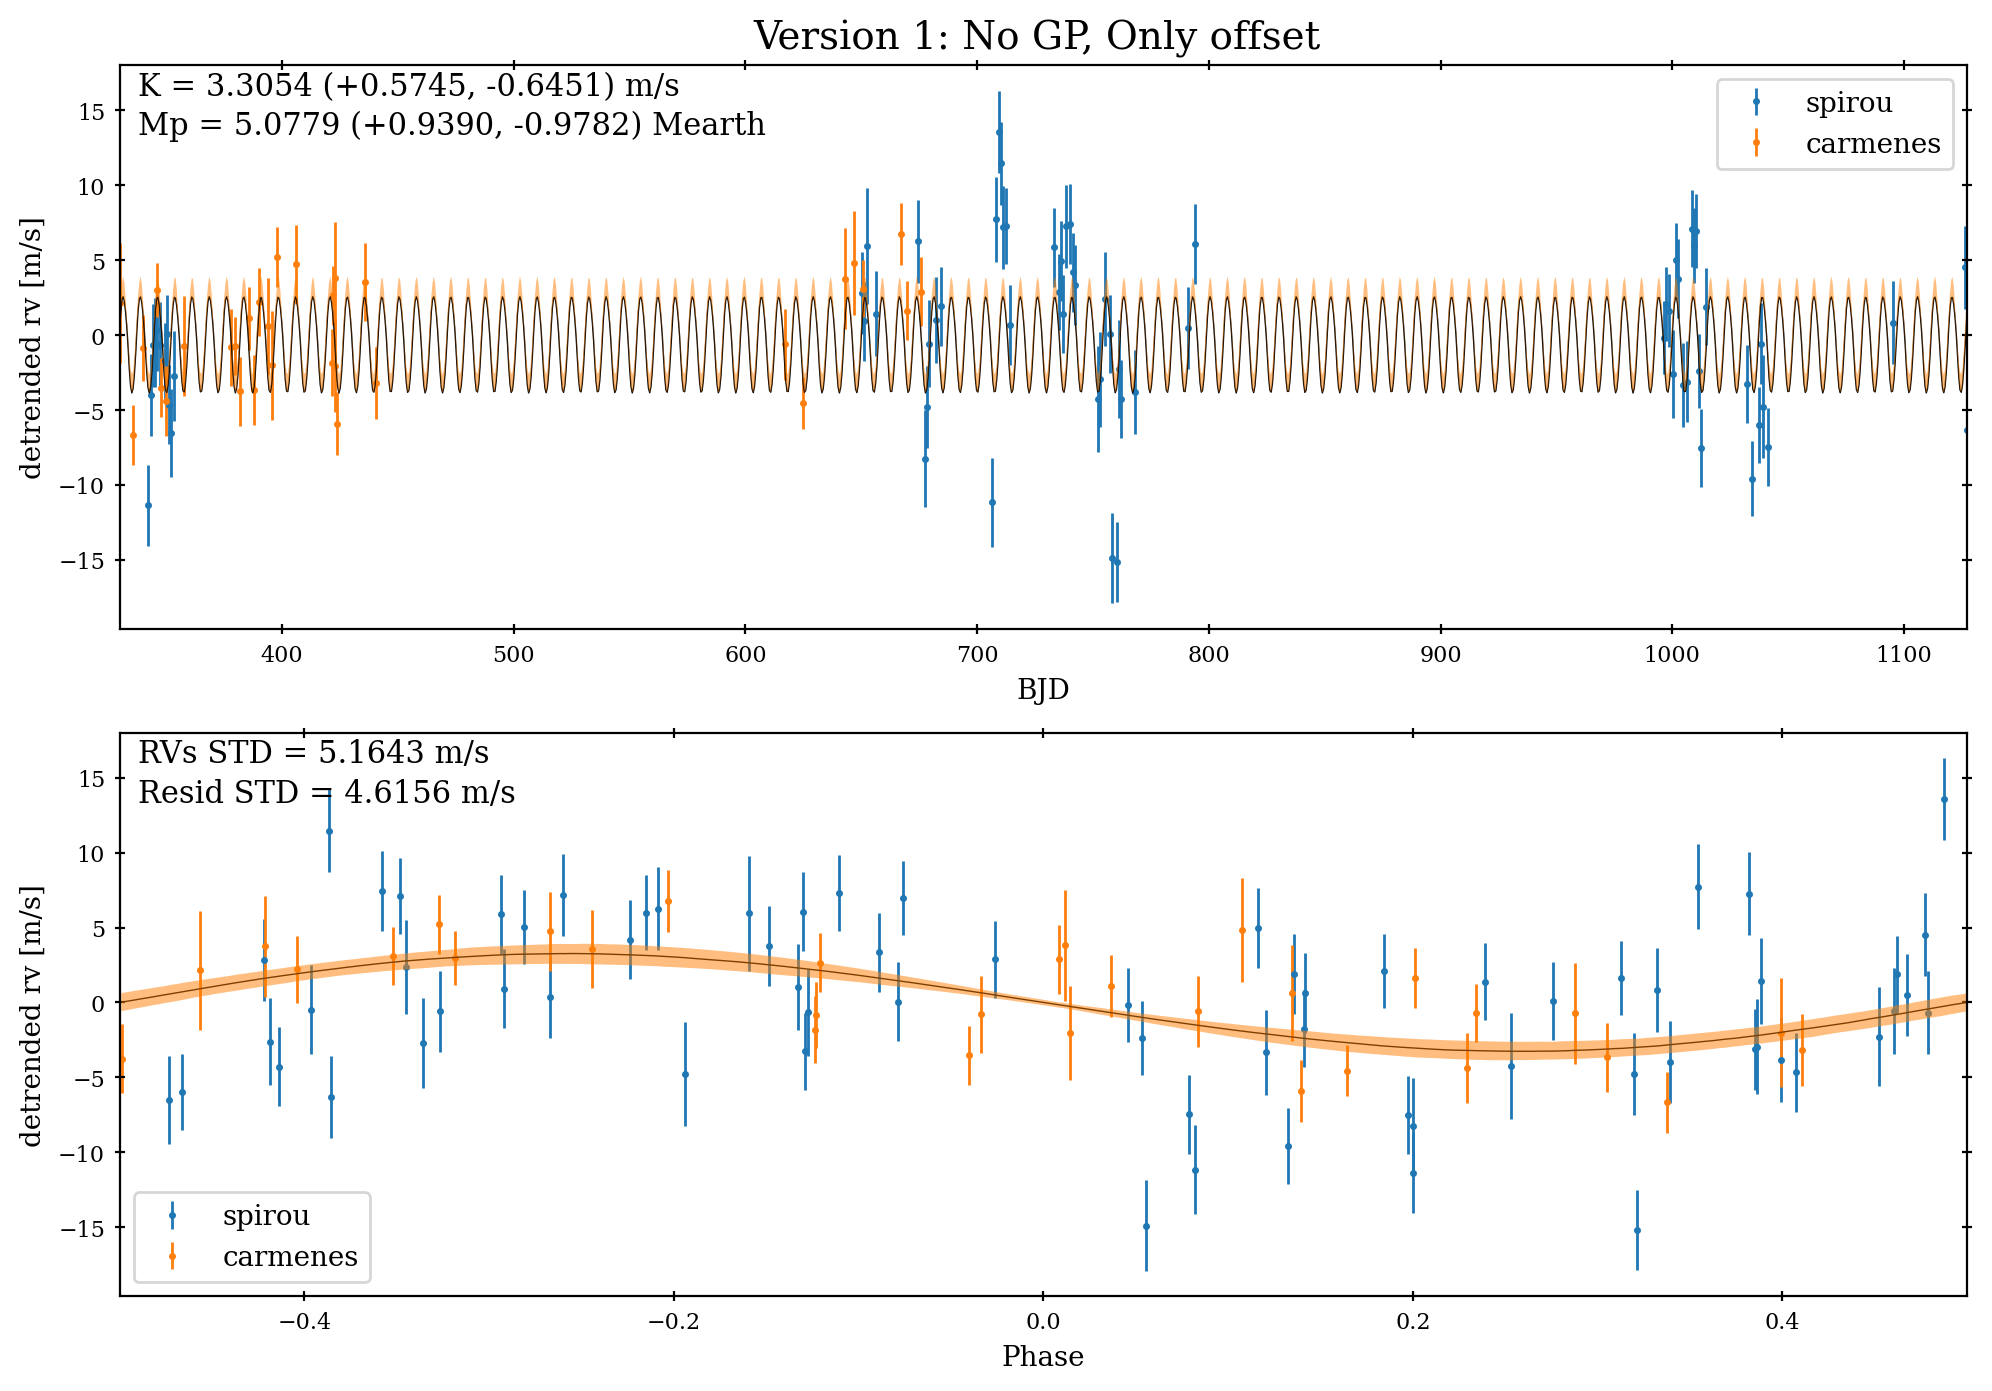

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
period = np.median(flat_samps["P"])
t0_ = np.median(flat_samps["t0"])
rv_model = np.median(flat_samps['rv_model'].values, axis=-1)
rv_model_pred = np.percentile(flat_samps["rv_model_pred"].values, [16,50,84], axis=-1)
mean = np.median(flat_samps["mean"].values, axis=-1)
sigma = np.median(flat_samps["sigma"].values, axis=-1)
means = dict()
jitters = dict()
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    log_sigmas = a_u(np.median(flat_samps["log_sigmas_rv"].values, axis=-1)[i], 
                     np.quantile(flat_samps["log_sigmas_rv"].values, q=0.84, axis=-1)[i], 
                     np.quantile(flat_samps["log_sigmas_rv"].values, q=0.16, axis=-1)[i])
    jitters[name] = np.e**log_sigmas
    means[name] = a_u(np.median(flat_samps["mean"].values, axis=-1)[m].mean(), 
                     np.quantile(flat_samps["mean"].values, q=0.84, axis=-1)[m].mean(),
                     np.quantile(flat_samps["mean"].values, q=0.16, axis=-1)[m].mean())

# logsigma_rv = a_u(sigma, np.std(flat_samps["sigma"].values, axis=-1))
# rv_jitter_ = np.e**logsigma_rv
residuals = y_rv - rv_model

ax[0].plot(t_rv, rv_model_pred[0], "k", lw=0.5)
art = ax[0].fill_between(t_rv, rv_model_pred[0], rv_model_pred[2], color="#FF7F00", alpha=0.5, zorder=2) #color="#988ED5"
art.set_edgecolor("none")
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], y_rv[m] - mean[m], yerr=yerr_rv[m], fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
    
ax[0].legend(fontsize=10)
ax[0].set_xlim(x_rv.min(), x_rv.max())
ax[0].set_xlabel("BJD")
ax[0].set_ylabel("detrended rv [m/s]")
ax[0].set_title("Version 1: No GP, Only offset", fontsize=14)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    fold = (x_rv[m] - t0_ + 0.5 * period) % period - 0.5 * period
    inds = np.argsort(fold)
    ax[1].errorbar(fold[inds]/period, y_rv[m][inds] - mean[m][inds], yerr=yerr_rv[m][inds], fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)

fold2 = (t_rv - t0_ + 0.5 * period) % period - 0.5 * period
inds2 = np.argsort(fold2)
ax[1].plot(fold2[inds2]/period, rv_model_pred[1][inds2], "k", lw=0.5)
art = ax[1].fill_between(fold2[inds2]/period, rv_model_pred[0][inds2], rv_model_pred[2][inds2], color="#FF7F00", alpha=0.5, zorder=2) #color="#988ED5"
art.set_edgecolor("none")
ax[1].legend(fontsize=10)
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_xlabel("Phase")
ax[1].set_ylabel("detrended rv [m/s]")
ax[0].text(.01, .99, 'K = {k:.4f} m/s'.format(k=params['K']), fontsize=11, ha='left', va='top', transform=ax[0].transAxes)
ax[0].text(.01, .92, 'Mp = {k:.4f} Mearth'.format(k=params['m_pl']), fontsize=11, ha='left', va='top', transform=ax[0].transAxes)

ax[1].text(.01, .99, 'RVs STD = {k:.4f} m/s'.format(k=np.std(y_rv)), fontsize=11, ha='left', va='top', transform=ax[1].transAxes)
ax[1].text(.01, .92, 'Resid STD = {k:.4f} m/s'.format(k=np.std(residuals)), fontsize=11, ha='left', va='top', transform=ax[1].transAxes)
plt.tight_layout()
plt.savefig('rv_fit_toi4438_v1_gplc_persector.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

### LC fit

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

lc_mod = map_soln["light_curves"][:, 0] + map_soln["lc_mean"] # lc + mean
gp_only = map_soln["gp_lc_pred"] # gp model (on top of lc + mean)

# first plot the gp model
ax = axes[0]
ax.plot(x, y, "k", label="data")
ax.plot(x, gp_only, color="C2", label="gp model")
ax.legend(fontsize=10)
ax.set_ylabel("relative flux [ppt]")

# then detrend data for gp model and plot the lc model
ax = axes[1]
ax.plot(x, y - gp_only, "k", label="de-trended data")
ax.plot(x, lc_mod, label="LC - planet {0}".format(b))
ax.legend(fontsize=10, loc=3)
ax.set_ylabel("de-trended flux [ppt]")

# residuals of gp + lc model
ax = axes[2]
ax.plot(x, y - lc_mod - gp_only, "k")
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("residuals [ppt]")
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("time [days]")
plt.xlim(345, 360)

#plt.savefig('toi4438_lc.png', dpi=300)

### Periodogram with Residuals